In [1]:
import sys
#sys.path.insert(0,'/eos/home-a/antoniov/SWAN_projects/env/uproot4/lib/python3.7/site-packages')
sys.path.insert(0,'/eos/home-a/antoniov/SWAN_projects/env/uproot/lib/python3.8/site-packages')
print ( sys.path )

import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import mplhep
from matplotlib.colors import LogNorm
from joblib import dump, load
plt.style.use(mplhep.style.CMS)

import sklearn
import tensorflow as tf
from tensorflow import keras

print ( "sklearn: {}".format(sklearn.__version__) )
print ( "tensorflow: {}".format(tf.__version__) )

['/eos/home-a/antoniov/SWAN_projects/env/uproot/lib/python3.8/site-packages', '/cvmfs/sft.cern.ch/lcg/views/LCG_99/x86_64-centos7-gcc8-opt/python', '/cvmfs/sft.cern.ch/lcg/views/LCG_99/x86_64-centos7-gcc8-opt/lib', '', '/cvmfs/sft.cern.ch/lcg/views/LCG_99/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages', '/cvmfs/sft.cern.ch/lcg/releases/Python/3.8.6-3199b/x86_64-centos7-gcc8-opt/lib/python38.zip', '/cvmfs/sft.cern.ch/lcg/releases/Python/3.8.6-3199b/x86_64-centos7-gcc8-opt/lib/python3.8', '/cvmfs/sft.cern.ch/lcg/releases/Python/3.8.6-3199b/x86_64-centos7-gcc8-opt/lib/python3.8/lib-dynload', '/eos/home-a/antoniov/SWAN_projects/env/uproot/lib/python3.8/site-packages', '/cvmfs/sft.cern.ch/lcg/views/LCG_99/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/IPython/extensions', '/scratch/antoniov/.ipython']
sklearn: 0.23.2
tensorflow: 2.3.1


In [2]:
# run_ranges_periods, df_run_ranges, fiducial_cuts, fiducial_cuts_all, aperture_period_map, aperture_parametrisation, check_aperture, get_data, process_data_protons_multiRP
from processing import *

save_figures = False

test_sample_ratio = 0.40

run_tables = False

use_keras = True

if use_keras:
    # DNN
    #prob_cut = 0.1339 # TPR ~95%
    #prob_cut = 0.2637 # TPR ~90%
    #prob_cut = 0.4260 # TPR ~85%
    #prob_cut = 0.6445 # TPR ~75%
    #prob_cut = 0.75
    #prob_cut = 0.2815 # FPR ~0.05%
    prob_cut = 0.32
else:
    # BDT
    #prob_cut = 0.2764 # TPR ~95% 
    #prob_cut = 0.6497 # TPR ~90%
    #prob_cut = 0.6910
    #prob_cut = 0.2764 # FPR ~0.05%
    prob_cut = 0.47
print ( prob_cut )

{'2017B': 2.360904801, '2017C1': 5.313012839, '2017C2': 3.264135878, '2017D': 4.074723964, '2017E': 8.958810514, '2017F1': 1.708478656, '2017F2': 7.877903151, '2017F3': 3.632463163}
Luminosity: 37.190432966
0.32


### Load classifier

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

#clf = load( "model/ada_clf.joblib" )
#clf = load( "model/adaboost_clf_test-multiRP_2021_01_14-21_04_56.joblib" )
scaler = None
clf = None
if use_keras:
    scaler_path = "model/standard_scaler.joblib"
    model_path = "model/keras_model.h5"
#     scaler_path = "model/standard_scaler_test-multiRP_2021_01_22-17_27_08.joblib"
#     model_path = "model/keras_model_test-multiRP_2021_01_22-17_46_10.h5"
    scaler = load( scaler_path )
    clf = keras.models.load_model( model_path )
else:
    model_path = "model/ada_clf.joblib"
#     model_path = "model/adaboost_clf_test-multiRP_2021_01_14-21_04_56.joblib"
    clf = load( model_path )
print( clf )

### Event selection and append classifier predictions

In [4]:
def select_events( df_events, clf=None, use_keras=False, prob_cut=-1. ):
    msk_ = ( ( df_events.loc[ :, "jet0_corrmass"] >= 50.0 ) &
             ( df_events.loc[ :, "jet0_corrmass"] <= 110.0 ) &
             ( df_events.loc[ :, "num_bjets_ak4"] == 0 ) )
    df_events = df_events.loc[ msk_ ]
    
    variables_ = [ 'jet0_pt', 'jet0_eta', 'jet0_phi', 'jet0_tau1', 'jet0_tau2', 'muon0_pt', 'muon0_eta', 'muon0_phi', 'met', 'met_phi',
                   'pfcand_nextracks', 'WLeptonicPt', 'WLeptonicPhi', 'recoMWW', 'recoRapidityWW', 'MX', 'YX' ]
#     variables_ = [ 'jet0_pt', 'jet0_phi', 'jet0_tau1', 'jet0_tau2', 'pfcand_nextracks', 
#                    'WLeptonicPt', 'WLeptonicPhi', 'recoMWW', 'recoRapidityWW', 'MX', 'YX' ]
    
    if clf:
        X_ = df_events[ variables_ ]
        y_proba = None
        y_pred = None
        if use_keras:
            X_scaled_ = scaler.transform( X_ )
            y_proba = np.array( clf.predict( X_scaled_ ) )
            y_pred = np.array( ( y_proba >= prob_cut ) if prob_cut > 0. else np.full_like( y_proba, -1 ) ).astype( "int32" )
        else:
            y_proba = np.array( clf.predict_proba( X_ )[:,1] )
            y_pred = np.array( ( y_proba >= prob_cut ) if prob_cut > 0. else clf.predict( X_ ) ).astype( "int32" )
        df_events[ "probability" ] = y_proba
        df_events[ "category" ] = y_pred
        
    return df_events

### Signal

In [5]:
#label = "GGToWW-AQGC-test-A0W1e-6"
#label = "GGToWW-AQGC-test-A0W2e-6"
#label = "GGToWW-AQGC-test-A0W5e-6"
labels_signals = [ "GGToWW-AQGC-A0W1e-6", "GGToWW-AQGC-A0W2e-6", "GGToWW-AQGC-A0W5e-6" ]

# fileNames_signal = [
#     #"output-GGToWW-AQGC-test-A0W1e-6.h5"
#     #"output-GGToWW-AQGC-test-A0W2e-6.h5"
#     "output-GGToWW-AQGC-test-A0W5e-6.h5"
# ]
fileNames_signals = {
    "GGToWW-AQGC-A0W1e-6": [ "output-GGToWW-AQGC-A0W1e-6.h5" ],
    "GGToWW-AQGC-A0W2e-6": [ "output-GGToWW-AQGC-A0W2e-6.h5" ],
    "GGToWW-AQGC-A0W5e-6": [ "output-GGToWW-AQGC-A0W5e-6.h5" ]
    }

df_counts_signals = {}
df_signals_protons_multiRP_index = {}
df_signals_protons_multiRP_events = {}

for label_ in labels_signals:
    import time
    print( time.strftime("%Y/%m/%d %H:%M:%S", time.localtime() ) )
    time_s_ = time.time()

    #df_counts_signal, df_protons_multiRP_signal, df_protons_singleRP_signal, df_ppstracks_signal = 4 * [None]
    #df_protons_multiRP_signal_index, df_protons_multiRP_signal_events, df_ppstracks_signal_index = 3 * [None]

    if run_tables:
        with pd.HDFStore( "reduced-data-store-{}.h5".format( label_ ), complevel=5 ) as store_:

            df_counts_signal_, df_protons_multiRP_signal_, df_protons_singleRP_signal_, df_ppstracks_signal_ = get_data( fileNames_signals[ label_ ] )
            df_protons_multiRP_signal_index_, df_protons_multiRP_signal_events_, df_ppstracks_signal_index_ = process_data_protons_multiRP( df_protons_multiRP_signal_, df_ppstracks_signal_, apply_fiducial=True, runOnMC=True )

            store_[ "counts" ] = df_counts_signal_
            store_[ "protons_multiRP"] = df_protons_multiRP_signal_index_
            store_[ "events_multiRP" ] = df_protons_multiRP_signal_events_
    
    with pd.HDFStore( "reduced-data-store-{}.h5".format( label_ ), 'r' ) as store_:
        df_counts_signals[ label_ ] = store_[ "counts" ]
        df_signals_protons_multiRP_index[ label_ ] = store_[ "protons_multiRP" ]
        df_signals_protons_multiRP_events[ label_ ] = store_[ "events_multiRP" ]

    time_e_ = time.time()
    print ( "Total time elapsed: {:.0f}".format( time_e_ - time_s_ ) )

2021/04/17 00:58:19
Total time elapsed: 0
2021/04/17 00:58:19
Total time elapsed: 0
2021/04/17 00:58:19
Total time elapsed: 0


In [6]:
#df_protons_multiRP_signal_index[:20]

df_signals_protons_multiRP_index[ "GGToWW-AQGC-A0W5e-6" ][:20]

xi       thx       thy         t  ismultirp  \
run lumiblock event  slice                                                      
1   6049      104823 0      0.040114  0.000016 -0.000033 -0.055696          1   
                     0      0.183088 -0.000107  0.000127 -0.986969          1   
              104872 0      0.085650 -0.000082 -0.000057 -0.392038          1   
                     0      0.044953 -0.000032 -0.000003 -0.043198          1   
    6051      105004 0      0.070999 -0.000085  0.000022 -0.306888          1   
                     0      0.065987  0.000072  0.000030 -0.241601          1   
              105026 0      0.046328 -0.000019 -0.000024 -0.038161          1   
                     0      0.149583 -0.000080  0.000078 -0.471365          1   
              105090 0      0.124829 -0.000117 -0.000037 -0.570310          1   
                     0      0.091662  0.000042 -0.000034 -0.118994          1   
    6052      105102 0      0.040554  0.000034 -0.000030 -0.084765          1   
                     0      0.038650  0.000057  0.000003 -0.134480          1   
              105168 0      0.107580  0.000026  0.000030 -0.070771          1   
                     0      0.166825 -0.000052  0.000065 -0.275437          1   
    6055      105434 0      0.122439  0.000020  0.000154 -0.913376          1   
                     0      0.071999  0.000036 -0.000082 -0.319079          1   
              105438 0      0.116528 -0.000081  0.000047 -0.337760          1   
                     0      0.090337 -0.000026 -0.000018 -0.045839          1   
    6056      105583 0      0.077867 -0.000013 -0.000030 -0.046573          1   
                     0      0.123415  0.000080  0.000022 -0.269354          1   

                            rpid  arm     jet0_pt  jet0_eta  jet0_phi  ...  \
run lumiblock event  slice                                             ...   
1   6049      104823 0       123    0  452.068115 -1.435060 -2.165500  ...   
                     0       123    1  452.068115 -1.435060 -2.165500  ...   
              104872 0       123    0  293.328430  1.216596 -2.577840  ...   
                     0       123    1  293.328430  1.216596 -2.577840  ...   
    6051      105004 0       123    0  434.371490  0.182227  1.019939  ...   
                     0       123    1  434.371490  0.182227  1.019939  ...   
              105026 0       123    0  465.300446 -1.146430 -1.029243  ...   
                     0       123    1  465.300446 -1.146430 -1.029243  ...   
              105090 0       123    0  722.540283 -0.183093  1.128231  ...   
                     0       123    1  722.540283 -0.183093  1.128231  ...   
    6052      105102 0       123    0  230.141449 -0.358933  0.542338  ...   
                     0       123    1  230.141449 -0.358933  0.542338  ...   
              105168 0       123    0  343.186157  1.413285  0.784215  ...   
                     0       123    1  343.186157  1.413285  0.784215  ...   
    6055      105434 0       123    0  559.050720  0.070478  2.299587  ...   
                     0       123    1  559.050720  0.070478  2.299587  ...   
              105438 0       123    0  636.379700  0.544857 -1.580128  ...   
                     0       123    1  636.379700  0.544857 -1.580128  ...   
    6056      105583 0       123    0  613.628723 -0.823772  0.281126  ...   
                     0       123    1  613.628723 -0.823772  0.281126  ...   

                            yhigh  eff_all_weighted  eff_all_2017B  \
run lumiblock event  slice                                           
1   6049      104823 0      4.298          0.206591       0.418829   
                     0      4.698          0.434932       0.436443   
              104872 0      4.298          0.339722       0.470016   
                     0      4.698          0.071505       0.087529   
    6051      105004 0      4.298          0.341967       0.458852   
                     0      4.698          0

In [7]:
for label_ in labels_signals:
    print ( label_ )
    print ( "Average proton efficiency: {}".format( np.mean( df_signals_protons_multiRP_index[ label_ ].loc[ :, [ "eff_all_weighted" ] ] ) ) )

GGToWW-AQGC-A0W1e-6
Average proton efficiency: eff_all_weighted    0.353368
dtype: float64
GGToWW-AQGC-A0W2e-6
Average proton efficiency: eff_all_weighted    0.369921
dtype: float64
GGToWW-AQGC-A0W5e-6
Average proton efficiency: eff_all_weighted    0.38019
dtype: float64


### Select events

In [8]:
for label_ in labels_signals:
    print ( df_signals_protons_multiRP_events[ label_ ].shape[0] )
    df_signals_protons_multiRP_events[ label_ ] = select_events( df_signals_protons_multiRP_events[ label_ ] )
    print ( df_signals_protons_multiRP_events[ label_ ].shape[0] )

3687
2651
6368
4729
14799
11165


### Set aside test sample

In [9]:
from sklearn.model_selection import train_test_split

for label_ in labels_signals:
    df_signal_ = df_signals_protons_multiRP_events[ label_ ]
    y_sig_ = np.ones( df_signal_.shape[0] )
    df_signal_train_, df_signal_test_, y_sig_train_, y_sig_test_ = train_test_split( df_signal_, y_sig_, test_size=test_sample_ratio, shuffle=True, random_state=12345 )
    print ( [ arr_.shape[0] for arr_ in ( df_signal_train_, df_signal_test_, y_sig_train_, y_sig_test_ ) ] )
    print ( df_signal_test_.mean() )
    df_signals_protons_multiRP_events[ label_ ] = df_signal_test_

[1590, 1061, 1590, 1061]
jet0_pt                    428.850272
jet0_eta                    -0.149090
jet0_phi                     0.058497
jet0_energy                570.372019
jet0_mass                   74.376918
jet0_corrmass               79.203663
jet0_tau1                    0.239439
jet0_tau2                    0.094261
jet0_vertexz                 0.000000
muon0_pt                   223.413035
muon0_eta                   -0.049471
muon0_phi                   -0.009195
muon0_energy               295.272954
muon0_charge                -0.014138
muon0_iso                    0.003828
muon0_dxy                    0.000620
muon0_dz                     0.002007
met                        194.596232
met_x                      -13.052421
met_y                       -2.097455
met_phi                      0.028091
nVertices                   29.796418
num_bjets_ak8                0.014138
num_bjets_ak4                0.000000
num_jets_ak4                 0.118756
pfcand_nextracks         

In [10]:
import json
samples_info = json.load( open( 'samples_info.json' ) )
samples_info

{'QCD_Pt_170to300_TuneCP5_13TeV_pythia8': [29829920.0, 103500, 2],
 'ExclusiveWW_a0w1e-6-SingleLepton-2017': [15000.0, 0.062086, 6],
 'GGToWW_bSM-A0W5e-6_13TeV-fpmc-herwig6': [993000.0, 0.148132, 6],
 'GGToWWToJJENu_PtL-15_13TeV-fpmc-herwig6': [295401.0, 0.0049534, 1],
 'QCD_Pt_1800to2400_TuneCP5_13TeV_pythia8': [2923941.0, 0.08743, 2],
 'DYJetsToLL_1J_TuneCP5_13TeV-amcatnloFXFX-pythia8': [95629091.0, 859.59, 12],
 'GGToWW_bSM-ACW5e-6_13TeV-fpmc-herwig6': [99500.0, 0.0487, 6],
 'QCD_Pt-300to470_MuEnrichedPt5_TuneCP5_13TeV_pythia8': [15679722.0,
  797.3526899999999,
  2],
 'ZZ_TuneCP5_13TeV-pythia8': [1949768.0, 16.523, 3],
 'QCD_Pt-170to300_MuEnrichedPt5_TuneCP5_13TeV_pythia8': [46438676.0,
  8654.49315,
  2],
 'WJetsToLNu_HT-1200To2500_TuneCP5_13TeV-madgraphMLM-pythia8': [20258624.0,
  1.02333,
  862],
 'W1JetsToLNu_LHEWpT_100-150_TuneCP5_13TeV-amcnloFXFX-pythia8': [73508344.0,
  286.1,
  862],
 'ST_t-channel_antitop_4f_inclusiveDecays_TuneCP5_13TeV-powhegV2-madspin-pythia8': [3939990

In [11]:
lumi = np.sum( list( lumi_periods.values() ) )
print ( lumi )

#labels_signals = [ "GGToWW-AQGC-test-A0W1e-6", "GGToWW-AQGC-test-A0W2e-6", "GGToWW-AQGC-test-A0W5e-6" ]
sample_names = {}
sample_names[ "GGToWW-AQGC-A0W1e-6" ] = "GGToWW_bSM-A0W1e-6_13TeV-fpmc-herwig6"
sample_names[ "GGToWW-AQGC-A0W2e-6" ] = "GGToWW_bSM-A0W2e-6_13TeV-fpmc-herwig6"
sample_names[ "GGToWW-AQGC-A0W5e-6" ] = "GGToWW_bSM-A0W5e-6_13TeV-fpmc-herwig6"

norm_factors = {}
for label_ in labels_signals:
    sample_nevents_, sample_cross_section_, _ = samples_info[ sample_names[ label_ ] ]
    norm_factors[ label_ ] = np.array( [ lumi / ( sample_nevents_ * test_sample_ratio ), sample_cross_section_*1000, 1.0 ] )
    print ( samples_info[ sample_names[ label_] ] )
    print ( norm_factors[ label_ ] )
    df_signals_protons_multiRP_events[ label_ ].loc[ :, "norm" ] = np.product( norm_factors[ label_ ] )

37.190432966
[993700.0, 0.0453974, 6]
[9.35655454e-05 4.53974000e+01 1.00000000e+00]
[880000.0, 0.0583158, 6]
[1.05654639e-04 5.83158000e+01 1.00000000e+00]
[993000.0, 0.148132, 6]
[9.36315029e-05 1.48132000e+02 1.00000000e+00]


/cvmfs/sft.cern.ch/lcg/views/LCG_99/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/cvmfs/sft.cern.ch/lcg/views/LCG_99/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [12]:
#df_protons_multiRP_signal_events[:20]
df_signals_protons_multiRP_events[ "GGToWW-AQGC-A0W5e-6" ][:20]

jet0_pt  jet0_eta  jet0_phi  jet0_energy  \
run lumiblock event  slice                                                
1   3763      376291 0      491.624542 -0.935359 -1.489962   732.582520   
    7241      224019 0      507.948212  0.613440  2.439400   613.992981   
    2313      231277 0      509.290222 -0.004071 -2.315313   520.237671   
    2811      281003 0      661.700317 -0.754391  0.331687   867.356873   
    2035      203474 0      428.233734 -0.069639  1.529636   442.012543   
    4520      451950 0      609.860901 -0.281126  3.122256   645.592224   
    4341      434089 0      506.645630 -0.292969 -1.317391   542.630798   
    3884      388365 0      371.927307 -1.517753  1.776402   896.260803   
    6051      105004 0      434.371490  0.182227  1.019939   449.743011   
    8452      345119 0      747.657410  0.310321 -1.066642   792.932678   
    8659      365809 0      689.485901  0.340038 -1.424023   739.480591   
    7073      207214 0      517.348877 -0.477656 -2.280631   591.151855   
    2171      217080 0      332.842804  0.187885  2.940385   350.657562   
    9293      429258 0      418.413544 -0.817576 -1.302049   578.539246   
    2750      274906 0      430.374054 -0.412377  0.482501   476.027863   
    3230      322943 0      340.627441  1.323690 -0.343493   690.273254   
    3874      387370 0      669.591431 -0.361471 -1.893959   727.374634   
    1321      132010 0      363.790710 -1.067463  1.670486   600.982544   
    8538      353751 0      390.134827 -1.418463 -2.841541   860.824280   
    7640      263932 0      596.327820  0.475591  0.780590   674.600220   

                            jet0_mass  jet0_corrmass  jet0_tau1  jet0_tau2  \
run lumiblock event  slice                                                   
1   3763      376291 0      87.009262      93.311020   0.189955   0.091808   
    7241      224019 0      59.881615      63.435555   0.122320   0.087507   
    2313      231277 0      78.674721      83.066315   0.167153   0.068816   
    2811      281003 0      83.025276      88.310974   0.093823   0.038832   
    2035      203474 0      67.190247      70.977638   0.199938   0.075120   
    4520      451950 0      82.690666      87.314346   0.146023   0.054075   
    4341      434089 0      77.434418      81.870644   0.188584   0.080840   
    3884      388365 0      82.606544      88.850281   0.325644   0.188727   
    6051      105004 0      71.536041      75.429672   0.196847   0.029367   
    8452      345119 0      51.483307      54.365879   0.087438   0.051468   
    8659      365809 0      76.281746      80.545479   0.127467   0.056815   
    7073      207214 0      88.687378      94.049332   0.167098   0.108033   
    2171      217080 0      69.576172      73.424744   0.191800   0.104582   
    9293      429258 0      78.716934      84.093880   0.281967   0.135372   
    2750      274906 0      72.543732      76.736191   0.174378   0.076003   
    3230      322943 0      53.507046      58.698479   0.256341   0.183751   
    3874      387370 0      69.714264      73.762207   0.187075   0.085648   
    1321      132010 0      71.804680      77.667259   0.188402   0.112387   
    8538      353751 0      81.315254      89.739426   0.337630   0.080295   
    7640      263932 0      69.626785      73.755974   0.174937   0.081290   

                            jet0_vertexz    muon0_pt  ...    ylow  yhigh  \
run lumiblock event  slice                            ...                  
1   3763      376291 0               0.0  363.717377  ... -10.098  4.298   
    7241      224019 0               0.0  343.836761  ... -10.098  4.298   
    2313      231277 0               0.0   65.639099  ... -10.098  4.298   
    2811      281003 0               0.0   52.352924  ... -10.098  4.298   
    2035      203474 0               0.0  152.427002  ... -10.098  4.298   
    4520      451950 0               0.0  114.265099  ... -10.098  4.298   
    4341      434089 0               0.0  412.658051  .

In [13]:
for label_ in labels_signals:
    print ( label_ )
    print ( "Average proton efficiency: {}".format( np.mean( df_signals_protons_multiRP_events[ label_ ].loc[ :, [ "eff_all_weighted" ] ] ) ) )

GGToWW-AQGC-A0W1e-6
Average proton efficiency: eff_all_weighted    0.126661
dtype: float64
GGToWW-AQGC-A0W2e-6
Average proton efficiency: eff_all_weighted    0.136382
dtype: float64
GGToWW-AQGC-A0W5e-6
Average proton efficiency: eff_all_weighted    0.143798
dtype: float64


### Background

In [14]:
resample_factor = 20
label = "data-random-resample_20"

fileNames_bkg = [
    "output-data-random-resample_20-2017B.h5",
    "output-data-random-resample_20-2017C.h5",
    "output-data-random-resample_20-2017D.h5",
    "output-data-random-resample_20-2017E.h5",
    "output-data-random-resample_20-2017F.h5"
]

import time
print( time.strftime("%Y/%m/%d %H:%M:%S", time.localtime() ) )
time_s_ = time.time()

df_counts_bkg, df_protons_multiRP_bkg, df_protons_singleRP_bkg, df_ppstracks_bkg = 4 * [None]
df_protons_multiRP_bkg_index, df_protons_multiRP_bkg_events, df_ppstracks_bkg_index = 3 * [None]

if run_tables:
    with pd.HDFStore( "reduced-data-store-{}.h5".format( label ), complevel=5 ) as store_:

        df_counts_bkg, df_protons_multiRP_bkg, df_protons_singleRP_bkg, df_ppstracks_bkg = get_data( fileNames_bkg )
        df_protons_multiRP_bkg_index, df_protons_multiRP_bkg_events, df_ppstracks_bkg_index = process_data_protons_multiRP( df_protons_multiRP_bkg, df_ppstracks_bkg, apply_fiducial=True, within_aperture=True, random_protons=True, runOnMC=False )

        store_[ "counts" ] = df_counts_bkg
        store_[ "protons_multiRP"] = df_protons_multiRP_bkg_index
        store_[ "events_multiRP" ] = df_protons_multiRP_bkg_events

with pd.HDFStore( "reduced-data-store-{}.h5".format( label ), 'r' ) as store_:
    df_counts_bkg = store_[ "counts" ]
    df_protons_multiRP_bkg_index = store_[ "protons_multiRP" ]
    df_protons_multiRP_bkg_events = store_[ "events_multiRP" ]
        
time_e_ = time.time()
print ( "Total time elapsed: {:.0f}".format( time_e_ - time_s_ ) )

2021/04/17 00:58:21
Total time elapsed: 3


In [15]:
df_counts_bkg

All          23824840
Jet          23824840
Muon         23420660
ProtonRnd     1010700
dtype: int64

In [16]:
df_protons_multiRP_bkg_index[:20]

xi       thx       thy         t  \
run    lumiblock event     slice                                           
297101 216       302550016 0      0.053462  0.000038 -0.000089 -0.375001   
                           0      0.108715  0.000028 -0.000071 -0.232221   
297292 87        162028576 0      0.041559  0.000090  0.000020 -0.347821   
                           0      0.078012  0.000043 -0.000074 -0.290854   
297050 23        23347598  0      0.039482 -0.000016 -0.000056 -0.137540   
                           0      0.070625  0.000103  0.000083 -0.692292   
       65        78788008  0      0.094874 -0.000006 -0.000094 -0.349458   
                           0      0.088130  0.000026 -0.000054 -0.144942   
       499       605989248 0      0.046020  0.000002  0.000030 -0.037710   
                           0      0.044068  0.000065 -0.000112 -0.680873   
297411 315       507722016 0      0.115323 -0.000139 -0.000009 -0.740176   
                           0      0.084233 -0.000093  0.000012 -0.349463   
       377       608603776 0      0.036584 -0.000039 -0.000136 -0.817616   
                           0      0.045994  0.000036 -0.000064 -0.218576   
297177 103       155861312 0      0.098408 -0.000010 -0.000046 -0.094515   
                           0      0.041949 -0.000018  0.000023 -0.036352   
       112       168879968 0      0.031520  0.000010 -0.000105 -0.458029   
                           0      0.082399  0.000013 -0.000029 -0.044631   
297057 359       451236608 0      0.106113  0.000021  0.000082 -0.282647   
                           0      0.121658 -0.000046  0.000034 -0.137009   

                                  ismultirp  rpid  arm     jet0_pt  jet0_eta  \
run    lumiblock event     slice                                               
297101 216       302550016 0              1   123    0  253.968201 -0.707324   
                           0              1   123    1  253.968201 -0.707324   
297292 87        162028576 0              1   123    0  211.335602  0.778516   
                           0              1   123    1  211.335602  0.778516   
297050 23        23347598  0              1   123    0  261.334717 -1.010473   
                           0              1   123    1  261.334717 -1.010473   
       65        78788008  0              1   123    0  223.571411 -0.640955   
                           0              1   123    1  223.571411 -0.640955   
       499       605989248 0              1   123    0  247.993744 -0.750684   
                           0              1   123    1  247.993744 -0.750684   
297411 315       507722016 0              1   123    0  202.485367 -1.909996   
                           0              1   123    1  202.485367 -1.909996   
       377       608603776 0              1   123    0  241.069107 -0.283513   
                           0              1   123    1  241.069107 -0.283513   
297177 103       155861312 0              1   123    0  205.575821  1.169397   
                           0              1   123    1  205.575821  1.169397   
       112       168879968 0              1   123    0  249.287399 -0.463456   
                           0              1   123    1  249.287399 -0.463456   
297057 359       451236608 0              1   123    0  394.285278  0.398574   
                           0              1   123    1  394.285278  0.398574   

                                  jet0_phi  ...    trackx2   tracky2  \
run    lumiblock event     slice            ...                        
297101 216       302550016 0      2.950644  ...   5.739746  1.239502   
                           0      2.950644  ...   8.485718  4.192871   
297292 87        162028576 0     -2.783820  ...   4.923218 -0.440033   
                           0     -2.783820  ...   6.192932  2.448730   
297050 23        23347598  0      1.135294  ...   3.563660  0.499451   
                           0      1.135294  ...   6.810974 -2.298340   
       65        78788008  0  

In [17]:
df_protons_multiRP_bkg_index[ [ "run_rnd", "lumiblock_rnd", "event_rnd", "slice_rnd",
                                "xi", "thx", "thy", "t", "ismultirp", "rpid", "arm",
                                "trackpixshift1", "rpid1", "trackpixshift2", "rpid2", "trackx1", "trackx2", "tracky1", "tracky2"] ][:20]

run_rnd  lumiblock_rnd  event_rnd  \
run    lumiblock event     slice                                      
297101 216       302550016 0       297101            164  232291296   
                           0       297101            164  232291296   
297292 87        162028576 0       297425             82  130758992   
                           0       297425             82  130758992   
297050 23        23347598  0       297100            271  492839776   
                           0       297100            271  492839776   
       65        78788008  0       297057            389  488075136   
                           0       297057            389  488075136   
       499       605989248 0       297469             61   99042640   
                           0       297469             61   99042640   
297411 315       507722016 0       297057            297  375215616   
                           0       297057            297  375215616   
       377       608603776 0       297292             68  127191856   
                           0       297292             68  127191856   
297177 103       155861312 0       297178            602  769280704   
                           0       297178            602  769280704   
       112       168879968 0       297296            231  335794368   
                           0       297296            231  335794368   
297057 359       451236608 0       297057            353  444560864   
                           0       297057            353  444560864   

                                  slice_rnd        xi       thx       thy  \
run    lumiblock event     slice                                            
297101 216       302550016 0             12  0.053462  0.000038 -0.000089   
                           0             12  0.108715  0.000028 -0.000071   
297292 87        162028576 0             12  0.041559  0.000090  0.000020   
                           0             12  0.078012  0.000043 -0.000074   
297050 23        23347598  0              6  0.039482 -0.000016 -0.000056   
                           0              6  0.070625  0.000103  0.000083   
       65        78788008  0              4  0.094874 -0.000006 -0.000094   
                           0              4  0.088130  0.000026 -0.000054   
       499       605989248 0             18  0.046020  0.000002  0.000030   
                           0             18  0.044068  0.000065 -0.000112   
297411 315       507722016 0             17  0.115323 -0.000139 -0.000009   
                           0             17  0.084233 -0.000093  0.000012   
       377       608603776 0              6  0.036584 -0.000039 -0.000136   
                           0              6  0.045994  0.000036 -0.000064   
297177 103       155861312 0             13  0.098408 -0.000010 -0.000046   
                           0             13  0.041949 -0.000018  0.000023   
       112       168879968 0              0  0.031520  0.000010 -0.000105   
                           0              0  0.082399  0.000013 -0.000029   
297057 359       451236608 0              7  0.106113  0.000021  0.000082   
                           0              7  0.121658 -0.000046  0.000034   

                                         t  ismultirp  rpid  arm  \
run    lumiblock event     slice                                   
297101 216       302550016 0     -0.375001          1   123    0   
                           0     -0.232221          1   123    1   
297292 87        162028576 0     -0.347821          1   123    0   
                           0     -0.290854          1   123    1   
297050 23        23347598  0     -0.137540          1   123    0   
                           0     -0.692292          1   123    1   
       65        78788008  0     -0.349458          1   123    0   
                           0     -0.144942          1   123    1   
       499       605989248 0     -0.037710          1   123    0   
                           0

### Select events

In [18]:
print ( df_protons_multiRP_bkg_events.shape[0] )
df_protons_multiRP_bkg_events = select_events( df_protons_multiRP_bkg_events )
print ( df_protons_multiRP_bkg_events.shape[0] )

813259
182082


### Set aside test sample

In [19]:
from sklearn.model_selection import train_test_split

df_bkg_ = df_protons_multiRP_bkg_events
y_bkg_ = np.zeros( df_bkg_.shape[0] )
df_bkg_train_, df_bkg_test_, y_bkg_train_, y_bkg_test_ = train_test_split( df_bkg_, y_bkg_, test_size=test_sample_ratio, shuffle=True, random_state=12345 )
print ( [ arr_.shape[0] for arr_ in ( df_bkg_train_, df_bkg_test_, y_bkg_train_, y_bkg_test_ ) ] )
print ( df_bkg_test_.mean() )
df_protons_multiRP_bkg_events = df_bkg_test_

[109249, 72833, 109249, 72833]
jet0_pt                   2.662878e+02
jet0_eta                 -5.625060e-03
jet0_phi                 -2.878534e-02
jet0_energy               4.766191e+02
jet0_mass                 6.691113e+01
jet0_corrmass             7.342904e+01
jet0_tau1                 3.017466e-01
jet0_tau2                 1.587424e-01
jet0_vertexz              0.000000e+00
muon0_pt                  1.287443e+02
muon0_eta                 3.070300e-03
muon0_phi                -1.032849e-02
muon0_energy              2.416604e+02
muon0_charge              4.889267e-02
muon0_iso                 1.580505e-02
muon0_dxy                 1.433688e-03
muon0_dz                  4.967655e-03
met                       9.362399e+01
met_x                    -1.245531e+00
met_y                     1.353378e+00
met_phi                   2.642119e-02
nVertices                 3.057129e+01
num_bjets_ak8             1.122293e-01
num_bjets_ak4             0.000000e+00
num_jets_ak4              1.44026

In [20]:
df_protons_multiRP_bkg_events[:20]

,,,,jet0_pt,jet0_eta,jet0_phi,jet0_energy,jet0_mass,jet0_corrmass,jet0_tau1,jet0_tau2,jet0_vertexz,muon0_pt,...,xlow,xhigh,ylow,yhigh,MX,YX,diffMWW_MX,ratioMWW_MX,shiftedRatioMWW_MX,diffYWW_YX
run,lumiblock,event,slice,,,,,,,,,,,,,,,,,,,,,
305814,1794,2890291968,18,239.590012,0.264975,-0.315881,267.634064,86.026741,93.576469,0.453450,0.145319,0.0,77.705704,...,1.995,24.334,-10.098,4.298,1174.730835,0.138622,-739.957031,0.370105,-0.629895,0.023330
305314,35,42090996,17,227.015244,1.975678,0.484816,837.381226,52.104668,58.510002,0.216346,0.126940,0.0,241.094238,...,1.995,24.334,-10.098,4.298,1477.510498,-0.339583,-929.272644,0.371055,-0.628945,1.935879
300811,455,753320768,12,203.901031,0.664670,-0.023537,271.354736,81.636284,87.623833,0.543827,0.213558,0.0,155.991089,...,1.995,24.334,-10.098,4.298,582.437439,0.088539,-133.679779,0.770482,-0.229518,0.165775
301959,1795,1626583936,9,328.944733,0.823401,0.101882,460.080048,80.884552,87.053375,0.244529,0.129657,0.0,129.903442,...,1.995,24.334,-10.098,4.298,929.896790,-0.123259,-412.294739,0.556623,-0.443377,0.892133
305310,94,94432728,16,592.379456,0.912557,-1.199621,867.208252,64.031731,70.352119,0.187994,0.122115,0.0,92.450363,...,1.995,24.334,-10.098,4.298,1499.636475,0.012914,-108.700073,0.927516,-0.072484,0.405153
306423,77,120406632,5,222.144272,0.466646,-0.069256,256.381348,52.622658,57.279972,0.238618,0.162122,0.0,161.145981,...,1.995,24.334,-10.098,4.298,1003.892578,0.097664,-607.147278,0.395207,-0.604793,0.387220
302479,200,244983072,0,239.347641,0.969057,1.885167,372.058868,67.994629,74.574226,0.389201,0.242023,0.0,142.785110,...,1.995,24.334,-10.098,4.298,1299.848389,0.057866,-845.614014,0.349452,-0.650548,0.936637
305862,192,243682368,16,325.476227,-0.918982,-0.457160,484.417908,71.634758,78.730865,0.311908,0.127922,0.0,68.674210,...,1.995,24.334,-10.098,4.298,769.815552,-0.062943,-124.659790,0.838065,-0.161935,-0.384231
306456,201,356844192,0,239.689346,2.032323,1.015836,933.987244,66.583191,74.571198,0.260678,0.186719,0.0,373.868164,...,1.995,24.334,-10.098,4.298,931.080383,-0.467641,-147.968140,0.841079,-0.158921,1.843491


### Data

In [21]:
label = "data"

fileNames_data = [
    'output-data-2017B.h5',
    'output-data-2017C.h5',
    'output-data-2017D.h5',
    'output-data-2017E.h5',
    'output-data-2017F.h5'
]

import time
print( time.strftime("%Y/%m/%d %H:%M:%S", time.localtime() ) )
time_s_ = time.time()

df_counts_data, df_protons_multiRP_data, df_protons_singleRP_data, df_ppstracks_data = 4 * [None]
df_protons_multiRP_data_index, df_protons_multiRP_data_events, df_ppstracks_data_index =  3 * [None]

if run_tables:
    with pd.HDFStore( "reduced-data-store-{}.h5".format( label ), complevel=5 ) as store_:

        df_counts_data, df_protons_multiRP_data, df_protons_singleRP_data, df_ppstracks_data = get_data( fileNames_data )
        df_protons_multiRP_data_index, df_protons_multiRP_data_events, df_ppstracks_data_index = process_data_protons_multiRP( df_protons_multiRP_data, df_ppstracks_data, apply_fiducial=True, within_aperture=True, runOnMC=False )

        store_[ "counts" ] = df_counts_data
        store_[ "protons_multiRP"] = df_protons_multiRP_data_index
        store_[ "events_multiRP" ] = df_protons_multiRP_data_events

with pd.HDFStore( "reduced-data-store-{}.h5".format( label ), 'r' ) as store_:
    df_counts_data = store_[ "counts" ]
    df_protons_multiRP_data_index = store_[ "protons_multiRP" ]
    df_protons_multiRP_data_events = store_[ "events_multiRP" ]
        
time_e_ = time.time()
print ( "Total time elapsed: {:.0f}".format( time_e_ - time_s_ ) )

2021/04/17 00:58:28
Total time elapsed: 0


In [22]:
df_protons_multiRP_data_index[:20]

xi       thx       thy         t  \
run    lumiblock event      slice                                           
297050 56        67470672   0      0.048623 -0.000018 -0.000086 -0.313532   
                            0      0.046856 -0.000036 -0.000017 -0.067508   
297292 87        163111984  0      0.056913  0.000022 -0.000069 -0.212477   
                            0      0.064017  0.000047 -0.000039 -0.150144   
297308 10        8493683    0      0.045801  0.000108 -0.000134 -1.193339   
                            0      0.105662 -0.000048  0.000023 -0.115943   
297219 836       1500202752 0      0.055662  0.000105  0.000002 -0.439648   
                            0      0.058800 -0.000027 -0.000051 -0.134417   
297101 387       522259744  0      0.044496  0.000025  0.000007 -0.029883   
                            0      0.097951 -0.000021  0.000026 -0.053014   
                 522966400  0      0.078112 -0.000042 -0.000094 -0.414409   
                            0      0.132600 -0.000058 -0.000014 -0.147670   
297219 2421      3327403520 0      0.085299  0.000069 -0.000019 -0.204593   
                            0      0.127697 -0.000097 -0.000022 -0.380567   
297425 58        93611808   0      0.044258 -0.000069 -0.000055 -0.313885   
                            0      0.052791 -0.000009 -0.000076 -0.238971   
297050 643       762052992  0      0.057468  0.000086 -0.000024 -0.322467   
                            0      0.034624  0.000066 -0.000067 -0.361813   
       645       764970432  0      0.048548 -0.000056 -0.000189 -1.556884   
                            0      0.058166  0.000020 -0.000008 -0.021391   

                                   ismultirp  rpid  arm     jet0_pt  jet0_eta  \
run    lumiblock event      slice                                               
297050 56        67470672   0              1   123    0  202.515182  0.893716   
                            0              1   123    1  202.515182  0.893716   
297292 87        163111984  0              1   123    0  203.507202 -1.973928   
                            0              1   123    1  203.507202 -1.973928   
297308 10        8493683    0              1   123    0  290.445282 -2.193158   
                            0              1   123    1  290.445282 -2.193158   
297219 836       1500202752 0              1   123    0  216.316467 -1.696552   
                            0              1   123    1  216.316467 -1.696552   
297101 387       522259744  0              1   123    0  246.350983 -0.594037   
                            0              1   123    1  246.350983 -0.594037   
                 522966400  0              1   123    0  205.969086 -0.020873   
                            0              1   123    1  205.969086 -0.020873   
297219 2421      3327403520 0              1   123    0  269.640167 -1.433301   
                            0              1   123    1  269.640167 -1.433301   
297425 58        93611808   0              1   123    0  235.661011 -0.611991   
                            0              1   123    1  235.661011 -0.611991   
297050 643       762052992  0              1   123    0  313.062256  0.543361   
                            0              1   123    1  313.062256  0.543361   
       645       764970432  0              1   123    0  204.346054  0.975615   
                            0              1   123    1  204.346054  0.975615   

                                   jet0_phi  ...    trackx2   tracky2  \
run    lumiblock event      slice            ...                        
297050 56        67470672   0     -0.328976  ...   4.422302  1.307373   
                            0     -0.328976  ...   2.531616  0.295807   
297292 87        163111984  0      1.850590  ...   5.884583  1.534546   
                            0      1.850590  ...   5.047729  0.774597   
297308 10        8493683    0     -0.117516  ...   6.457703  1.336426   
                            0     -0.117516  ...   7

In [23]:
df_protons_multiRP_data_events[:20]

jet0_pt  jet0_eta  jet0_phi  \
run    lumiblock event      slice                                   
297050 56        67470672   0      202.515182  0.893716 -0.328976   
297292 87        163111984  0      203.507202 -1.973928  1.850590   
297308 10        8493683    0      290.445282 -2.193158 -0.117516   
297219 836       1500202752 0      216.316467 -1.696552 -0.598422   
297101 387       522259744  0      246.350983 -0.594037 -0.614068   
                 522966400  0      205.969086 -0.020873 -2.800861   
297219 2421      3327403520 0      269.640167 -1.433301 -2.952790   
297425 58        93611808   0      235.661011 -0.611991 -1.141669   
297050 643       762052992  0      313.062256  0.543361  2.810169   
       645       764970432  0      204.346054  0.975615  0.864856   
                 764774720  0      207.091217 -1.865878  1.208510   
       774       896489920  0      271.473541 -1.300484 -1.209756   
       633       752284416  0      369.918152  1.142806 -2.564265   
297178 94        132224208  0      255.724213  0.363403  0.723975   
       312       419430400  0      211.951309 -1.351781 -2.307238   
                 418433600  0      226.731140 -0.617662  2.187049   
299062 231       376998688  0      232.567459 -2.280924 -2.570825   
       265       435268736  0      222.904709  1.173962 -2.920347   
297050 770       892737152  0      212.374405  0.932070  1.202618   
297101 743       944915392  0      244.500687  1.865416 -1.131230   

                                   jet0_energy   jet0_mass  jet0_corrmass  \
run    lumiblock event      slice                                           
297050 56        67470672   0       293.086853   33.124821      36.013985   
297292 87        163111984  0       748.566223    7.932750       9.116489   
297308 10        8493683    0      1320.782349   19.336693      21.763872   
297219 836       1500202752 0       611.905640    8.471152       9.395966   
297101 387       522259744  0       314.024353  105.189720     113.224373   
                 522966400  0       213.585434   24.429237      26.334103   
297219 2421      3327403520 0       605.542542   66.054741      74.511604   
297425 58        93611808   0       285.685150    8.973404       9.656996   
297050 643       762052992  0       366.401733   12.733925      13.652858   
       645       764970432  0       314.931793   38.758247      42.496670   
                 764774720  0       689.145996   51.603043      58.100441   
       774       896489920  0       538.399475   12.169693      13.640055   
       633       752284416  0       651.897156  101.549835     113.106056   
297178 94        132224208  0       294.146423   94.251205     101.195580   
       312       419430400  0       447.219910   82.046196      92.276543   
                 418433600  0       276.769562   11.665710      12.559964   
299062 231       376998688  0      1151.939331   48.901123      55.948681   
       265       435268736  0       400.437347   29.365957      32.869465   
297050 770       892737152  0       321.996979   72.406342      78.701492   
297101 743       944915392  0       812.360657   46.223228      52.146740   

                                   jet0_tau1  jet0_tau2  jet0_vertexz  \
run    lumiblock event      slice                                       
297050 56        67470672   0       0.151150   0.088942           0.0   
297292 87        163111984  0       0.136313   0.113655           0.0   
297308 10        8493683    0       0.184098   0.147928           0.0   
297219 836       1500202752 0       0.131184   0.102431           0.0   
297101 387       522259744  0       0.454587   0.234689           0.0   
                 522966400  0       0.221655   0.189757           0.0   
297219 2421      3327403520 0       0.281466   0.167799           0.0   
297425 58        93611808   0       0.125168   0.107975           0.0   
297050 643       762052992  0       0.100087   0.082362           0.0   
       645       7649

### Append classifier predictions

In [24]:
df_signals_protons_multiRP_events_sigreg = {}
eff_signals_prob_cut = {}
for label_ in labels_signals:
    df_signals_protons_multiRP_events[ label_ ] = select_events( df_signals_protons_multiRP_events[ label_ ], clf=clf, use_keras=use_keras, prob_cut=prob_cut )
    msk_sig_ = ( df_signals_protons_multiRP_events[ label_ ][ "probability" ] >= prob_cut )
    df_signals_protons_multiRP_events_sigreg[ label_ ] = df_signals_protons_multiRP_events[ label_ ].loc[ msk_sig_ ]
    eff_prob_cut_ = ( df_signals_protons_multiRP_events_sigreg[ label_ ].shape[0] / df_signals_protons_multiRP_events[ label_ ].shape[0] )
    eff_signals_prob_cut[ label_ ] = eff_prob_cut_
    
print ( eff_signals_prob_cut )
df_signals_protons_multiRP_events[ "GGToWW-AQGC-A0W5e-6" ][:20]

{'GGToWW-AQGC-A0W1e-6': 0.8991517436380773, 'GGToWW-AQGC-A0W2e-6': 0.9275898520084567, 'GGToWW-AQGC-A0W5e-6': 0.9594715629198388}


jet0_pt  jet0_eta  jet0_phi  jet0_energy  \
run lumiblock event  slice                                                
1   3763      376291 0      491.624542 -0.935359 -1.489962   732.582520   
    7241      224019 0      507.948212  0.613440  2.439400   613.992981   
    2313      231277 0      509.290222 -0.004071 -2.315313   520.237671   
    2811      281003 0      661.700317 -0.754391  0.331687   867.356873   
    2035      203474 0      428.233734 -0.069639  1.529636   442.012543   
    4520      451950 0      609.860901 -0.281126  3.122256   645.592224   
    4341      434089 0      506.645630 -0.292969 -1.317391   542.630798   
    3884      388365 0      371.927307 -1.517753  1.776402   896.260803   
    6051      105004 0      434.371490  0.182227  1.019939   449.743011   
    8452      345119 0      747.657410  0.310321 -1.066642   792.932678   
    8659      365809 0      689.485901  0.340038 -1.424023   739.480591   
    7073      207214 0      517.348877 -0.477656 -2.280631   591.151855   
    2171      217080 0      332.842804  0.187885  2.940385   350.657562   
    9293      429258 0      418.413544 -0.817576 -1.302049   578.539246   
    2750      274906 0      430.374054 -0.412377  0.482501   476.027863   
    3230      322943 0      340.627441  1.323690 -0.343493   690.273254   
    3874      387370 0      669.591431 -0.361471 -1.893959   727.374634   
    1321      132010 0      363.790710 -1.067463  1.670486   600.982544   
    8538      353751 0      390.134827 -1.418463 -2.841541   860.824280   
    7640      263932 0      596.327820  0.475591  0.780590   674.600220   

                            jet0_mass  jet0_corrmass  jet0_tau1  jet0_tau2  \
run lumiblock event  slice                                                   
1   3763      376291 0      87.009262      93.311020   0.189955   0.091808   
    7241      224019 0      59.881615      63.435555   0.122320   0.087507   
    2313      231277 0      78.674721      83.066315   0.167153   0.068816   
    2811      281003 0      83.025276      88.310974   0.093823   0.038832   
    2035      203474 0      67.190247      70.977638   0.199938   0.075120   
    4520      451950 0      82.690666      87.314346   0.146023   0.054075   
    4341      434089 0      77.434418      81.870644   0.188584   0.080840   
    3884      388365 0      82.606544      88.850281   0.325644   0.188727   
    6051      105004 0      71.536041      75.429672   0.196847   0.029367   
    8452      345119 0      51.483307      54.365879   0.087438   0.051468   
    8659      365809 0      76.281746      80.545479   0.127467   0.056815   
    7073      207214 0      88.687378      94.049332   0.167098   0.108033   
    2171      217080 0      69.576172      73.424744   0.191800   0.104582   
    9293      429258 0      78.716934      84.093880   0.281967   0.135372   
    2750      274906 0      72.543732      76.736191   0.174378   0.076003   
    3230      322943 0      53.507046      58.698479   0.256341   0.183751   
    3874      387370 0      69.714264      73.762207   0.187075   0.085648   
    1321      132010 0      71.804680      77.667259   0.188402   0.112387   
    8538      353751 0      81.315254      89.739426   0.337630   0.080295   
    7640      263932 0      69.626785      73.755974   0.174937   0.081290   

                            jet0_vertexz    muon0_pt  ...           MX  \
run lumiblock event  slice                            ...                
1   3763      376291 0               0.0  363.717377  ...  1139.504395   
    7241      224019 0               0.0  343.836761  ...  1372.561401   
    2313      231277 0               0.0   65.639099  ...  1142.306641   
    2811      281003 0               0.0   52.352924  ...  1570.477661   
    2035      203474 0               0.0  152.427002  ...  1006.325684   
    4520      451950 0               0.0  114.265099  ...  1151.208740   
    4341      434089 0               0.0  412.658051  ...   964.935547 

In [25]:
df_protons_multiRP_bkg_events = select_events( df_protons_multiRP_bkg_events, clf=clf, use_keras=use_keras, prob_cut=prob_cut )
norm_factors['Bkg'] = np.array( [ ( 1. / resample_factor ) * ( 1. / test_sample_ratio ) ] )
df_protons_multiRP_bkg_events[ "norm" ] = np.product( norm_factors['Bkg'] )

msk_bkg = ( df_protons_multiRP_bkg_events[ "probability" ] < prob_cut )
df_protons_multiRP_bkg_events_bkgreg = df_protons_multiRP_bkg_events.loc[ msk_bkg ]

msk_bkg = ( df_protons_multiRP_bkg_events[ "probability" ] >= prob_cut )
df_protons_multiRP_bkg_events_sigreg = df_protons_multiRP_bkg_events.loc[ msk_bkg ]

In [26]:
df_protons_multiRP_bkg_events_bkgreg[:20]

,,,,jet0_pt,jet0_eta,jet0_phi,jet0_energy,jet0_mass,jet0_corrmass,jet0_tau1,jet0_tau2,jet0_vertexz,muon0_pt,...,yhigh,MX,YX,diffMWW_MX,ratioMWW_MX,shiftedRatioMWW_MX,diffYWW_YX,probability,category,norm
run,lumiblock,event,slice,,,,,,,,,,,,,,,,,,,,,
305814,1794,2890291968,18,239.590012,0.264975,-0.315881,267.634064,86.026741,93.576469,0.453450,0.145319,0.0,77.705704,...,4.298,1174.730835,0.138622,-739.957031,0.370105,-0.629895,0.023330,0.000026,0,0.125
305314,35,42090996,17,227.015244,1.975678,0.484816,837.381226,52.104668,58.510002,0.216346,0.126940,0.0,241.094238,...,4.298,1477.510498,-0.339583,-929.272644,0.371055,-0.628945,1.935879,0.000004,0,0.125
300811,455,753320768,12,203.901031,0.664670,-0.023537,271.354736,81.636284,87.623833,0.543827,0.213558,0.0,155.991089,...,4.298,582.437439,0.088539,-133.679779,0.770482,-0.229518,0.165775,0.002240,0,0.125
301959,1795,1626583936,9,328.944733,0.823401,0.101882,460.080048,80.884552,87.053375,0.244529,0.129657,0.0,129.903442,...,4.298,929.896790,-0.123259,-412.294739,0.556623,-0.443377,0.892133,0.000048,0,0.125
305310,94,94432728,16,592.379456,0.912557,-1.199621,867.208252,64.031731,70.352119,0.187994,0.122115,0.0,92.450363,...,4.298,1499.636475,0.012914,-108.700073,0.927516,-0.072484,0.405153,0.005566,0,0.125
306423,77,120406632,5,222.144272,0.466646,-0.069256,256.381348,52.622658,57.279972,0.238618,0.162122,0.0,161.145981,...,4.298,1003.892578,0.097664,-607.147278,0.395207,-0.604793,0.387220,0.000340,0,0.125
302479,200,244983072,0,239.347641,0.969057,1.885167,372.058868,67.994629,74.574226,0.389201,0.242023,0.0,142.785110,...,4.298,1299.848389,0.057866,-845.614014,0.349452,-0.650548,0.936637,0.000001,0,0.125
305862,192,243682368,16,325.476227,-0.918982,-0.457160,484.417908,71.634758,78.730865,0.311908,0.127922,0.0,68.674210,...,4.298,769.815552,-0.062943,-124.659790,0.838065,-0.161935,-0.384231,0.004073,0,0.125
306456,201,356844192,0,239.689346,2.032323,1.015836,933.987244,66.583191,74.571198,0.260678,0.186719,0.0,373.868164,...,4.298,931.080383,-0.467641,-147.968140,0.841079,-0.158921,1.843491,0.000025,0,0.125


In [27]:
df_protons_multiRP_bkg_events_sigreg[:20]

,,,,jet0_pt,jet0_eta,jet0_phi,jet0_energy,jet0_mass,jet0_corrmass,jet0_tau1,jet0_tau2,jet0_vertexz,muon0_pt,...,yhigh,MX,YX,diffMWW_MX,ratioMWW_MX,shiftedRatioMWW_MX,diffYWW_YX,probability,category,norm
run,lumiblock,event,slice,,,,,,,,,,,,,,,,,,,,,
300515,11,18536480,13,615.006409,-0.216690,-1.072484,640.408875,77.763947,83.597794,0.167002,0.044098,0.0,98.742531,...,4.298,1370.264160,-0.164661,-173.765015,0.873189,-0.126811,-0.154455,0.457234,1,0.125
305814,930,1560237568,8,302.948578,-0.513439,-1.921366,362.941254,94.652115,103.443527,0.370347,0.113497,0.0,185.338928,...,4.298,1106.355591,0.376230,-397.371216,0.640829,-0.359171,-0.361957,0.388669,1,0.125
297178,550,708709248,13,221.877625,1.491963,0.847366,524.722412,71.261772,81.151344,0.343753,0.074503,0.0,217.999603,...,4.298,897.916931,-0.309277,270.206116,1.300925,0.300925,0.196673,0.806730,1,0.125
302597,783,659082624,18,276.228851,-0.448780,1.290860,319.457062,77.020638,83.354263,0.316436,0.178029,0.0,67.335747,...,4.298,719.382507,-0.205594,-137.731873,0.808542,-0.191458,0.007008,0.352124,1,0.125
302448,895,994272384,7,446.879272,-0.315642,-2.794472,485.120331,92.420639,99.697456,0.294389,0.118845,0.0,90.324516,...,4.298,972.322510,-0.329040,-64.756409,0.933400,-0.066600,0.125130,0.629492,1,0.125
305840,148,271326976,5,814.014038,0.216158,-0.658770,844.037659,74.257889,80.705811,0.118155,0.056090,0.0,804.826355,...,4.298,853.079346,-0.118308,798.733887,1.936295,0.936295,0.410115,0.329960,1,0.125
300400,303,451374080,1,310.158478,-0.961494,3.035850,472.904327,63.106499,68.460693,0.197993,0.088541,0.0,76.261940,...,4.298,977.073486,-0.362928,-234.266418,0.760237,-0.239763,0.019705,0.381291,1,0.125
304625,423,626071552,15,344.051819,-1.474798,-0.868738,797.405334,66.776169,75.404495,0.278780,0.153430,0.0,80.420647,...,4.298,1207.714966,0.101299,80.954468,1.067031,0.067031,-0.341651,0.524987,1,0.125
301161,84,41769120,5,304.598846,0.774406,1.611541,412.672577,80.468674,86.302490,0.307346,0.108068,0.0,189.887360,...,4.298,679.023926,-0.233250,127.654358,1.187997,0.187997,0.253592,0.640358,1,0.125


In [28]:
df_protons_multiRP_data_events = select_events( df_protons_multiRP_data_events, clf=clf, use_keras=use_keras, prob_cut=prob_cut )
msk_data = ( df_protons_multiRP_data_events[ "probability" ] < prob_cut )
df_protons_multiRP_data_events_bkgreg = df_protons_multiRP_data_events.loc[ msk_data ]
df_protons_multiRP_data_events_bkgreg[:20]

<ipython-input-4-488c72c70375>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_events[ "probability" ] = y_proba
<ipython-input-4-488c72c70375>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df_events[ "category" ] = y_pred


jet0_pt  jet0_eta  jet0_phi  \
run    lumiblock event      slice                                   
297050 645       764774720  0      207.091217 -1.865878  1.208510   
299062 231       376998688  0      232.567459 -2.280924 -2.570825   
297050 770       892737152  0      212.374405  0.932070  1.202618   
297101 743       944915392  0      244.500687  1.865416 -1.131230   
297057 101       136385072  0      307.275391 -0.290665 -0.217202   
       22        29534116   0      447.185883 -0.000613  1.265319   
297296 110       160591456  0      229.555496  1.714147 -0.367528   
299064 79        121469456  0      214.286819 -2.187214  1.220086   
297178 738       915035968  0      226.047440 -0.022888 -1.384144   
       896       1084023168 0      205.290009 -0.097657  0.016637   
297057 364       457763680  0      217.345993  1.214966 -1.378114   
297411 202       311101824  0      219.790924 -2.368353  2.818387   
                 311786240  0      270.074158 -0.378071 -1.920915   
297057 568       692948096  0      213.219879 -1.470714 -2.308863   
297219 97        200319744  0      242.801559  0.713399  0.815354   
297292 22        41459812   0      252.164078 -1.048393  1.204812   
297296 364       518400896  0      200.231171 -0.385039  1.598874   
297469 68        110402680  0      299.802887  0.614384 -2.140643   
299061 210       277468768  0      278.535797  1.459662  1.076848   
       290       417032384  0      231.275436 -0.657904  0.417705   

                                   jet0_energy  jet0_mass  jet0_corrmass  \
run    lumiblock event      slice                                          
297050 645       764774720  0       689.145996  51.603043      58.100441   
299062 231       376998688  0      1151.939331  48.901123      55.948681   
297050 770       892737152  0       321.996979  72.406342      78.701492   
297101 743       944915392  0       812.360657  46.223228      52.146740   
297057 101       136385072  0       333.561981  75.597435      81.157578   
       22        29534116   0       455.648773  59.403088      63.905045   
297296 110       160591456  0       662.679016  62.635429      70.057175   
299064 79        121469456  0       968.898682  43.546558      50.042786   
297178 738       915035968  0       239.308609  54.963078      59.154415   
       896       1084023168 0       230.514969  94.591461     101.901360   
297057 364       457763680  0       406.121918  68.539909      76.722824   
297411 202       311101824  0      1187.344482  59.175331      66.670700   
                 311786240  0       305.275970  85.184479      91.596764   
297057 568       692948096  0       494.927399  59.698322      67.326691   
297219 97        200319744  0       317.729218  70.678551      76.140678   
297292 22        41459812   0       410.071136  49.020329      54.053425   
297296 364       518400896  0       234.823318  85.659828      92.155510   
297469 68        110402680  0       366.215942  49.689529      53.375587   
299061 210       277468768  0       635.765686  54.084526      60.971951   
       290       417032384  0       297.465454  76.189842      82.003342   

                                   jet0_tau1  jet0_tau2  jet0_vertexz  \
run    lumiblock event      slice                                       
297050 645       764774720  0       0.271658   0.183032           0.0   
299062 231       376998688  0       0.218909   0.095682           0.0   
297050 770       892737152  0       0.374500   0.200813           0.0   
297101 743       944915392  0       0.327528   0.167741           0.0   
297057 101       136385072  0       0.175973   0.072104           0.0   
       22        29534116   0       0.178149   0.053004           0.0   
297296 110       160591456  0       0.331651   0.181805           0.0   
299064 79        121469456  0       0.186450   0.108424           0.0   
297178 738       915035968  0       0.322128   0.151129           0.0   
       896       1084023168 0       0.54753

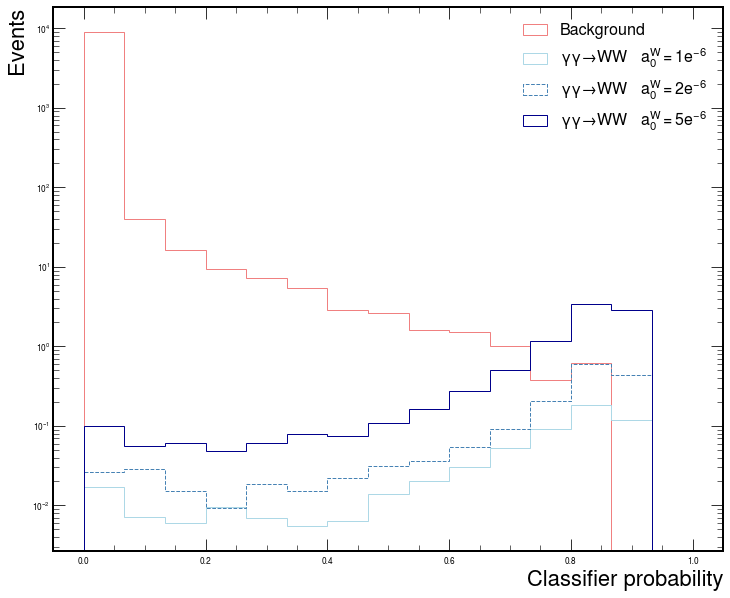

In [29]:
fig = plt.figure( figsize=(12,10) )

var_ = "probability"
hist_bins_ = 15
hist_range_ = (0.,1.)

labels_samples = {
    "GGToWW-AQGC-A0W1e-6": r"$\gamma\gamma \to WW \quad a_0^W=1e^{-6}$",
    "GGToWW-AQGC-A0W2e-6": r"$\gamma\gamma \to WW \quad a_0^W=2e^{-6}$",
    "GGToWW-AQGC-A0W5e-6": r"$\gamma\gamma \to WW \quad a_0^W=5e^{-6}$"
}

labels_ = [ "Background" ]
mc_list_var = [
    df_protons_multiRP_bkg_events[ var_ ]
    ]
weights_mc = [
    df_protons_multiRP_bkg_events["norm"]
    ]
for label_ in labels_signals:
    mc_list_var.append( df_signals_protons_multiRP_events[ label_ ][ var_ ] )
    weights_mc.append( ( df_signals_protons_multiRP_events[ label_ ]["norm"] * df_signals_protons_multiRP_events[ label_ ]["eff_all_weighted"] ) )
    labels_.append( labels_samples[ label_ ] )
colors_ = [ "lightcoral", "lightblue", "steelblue", "darkblue" ]
linestyles_ = [ "-", "-", "--", "-"]

for idx_ in range( len( mc_list_var ) ):
    plt.hist( mc_list_var[ idx_ ], weights=weights_mc[ idx_ ], histtype='step', color=colors_[ idx_ ], linestyle=linestyles_[ idx_ ],
              bins=hist_bins_, range=hist_range_, label=labels_[ idx_ ] )

# plt.hist( df_protons_multiRP_signal_events[ var_ ], histtype='step', color='skyblue', bins=hist_bins_, range=hist_range_,
#                                                     weights=( df_protons_multiRP_signal_events["norm"] * df_protons_multiRP_signal_events["eff_all_weighted"] ) )
plt.yscale('log')
plt.xlabel( "Classifier probability", fontsize=22 )
plt.ylabel( "Events", fontsize=22 )
plt.legend( fontsize=16 )
if save_figures:
    plt.savefig( "plots/ANN-Keras_Classifier_Probability_Background_vs_Signals_Normalized_test-multiRP_2021_01_22-17_46_10.pdf", bbox_inches='tight' )
    plt.savefig( "plots/ANN-Keras_Classifier_Probability_Background_vs_Signals_Normalized_test-multiRP_2021_01_22-17_46_10.png", bbox_inches='tight' )

y max. = 11410.1
y max. = 1085.5


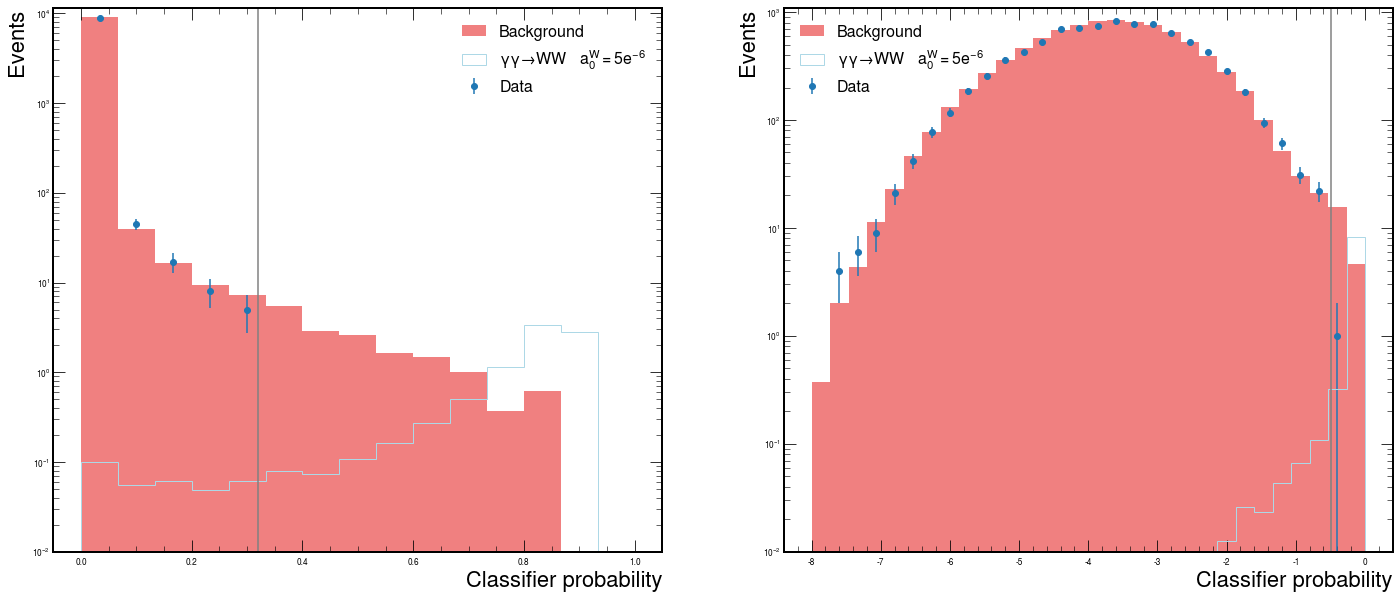

In [30]:
fig, axes = plt.subplots( 1, 2, figsize=(24,10) )

label_signal = "GGToWW-AQGC-A0W5e-6"

var_ = "probability"

hist_bins_ = 15
hist_range_ = (0.,1.)

counts_, bin_edges_ = np.histogram( df_protons_multiRP_data_events_bkgreg[ var_ ], bins=hist_bins_, range=hist_range_ )
errors_ = np.sqrt( counts_ )
bin_centres_ = ( bin_edges_[:-1] + bin_edges_[1:] ) / 2.
idx_ymax_ = np.argmax( counts_ )
y_max = counts_[idx_ymax_]
y_max += np.max( [ 2 * errors_[idx_ymax_], 0.30*y_max ] )
print ( "y max. = {}".format(y_max) )

axes[0].hist( df_protons_multiRP_bkg_events[ var_ ], bins=hist_bins_, range=hist_range_, color='lightcoral', weights=df_protons_multiRP_bkg_events[ "norm" ], label="Background" )
axes[0].hist( df_signals_protons_multiRP_events[ label_signal ][ var_ ], bins=hist_bins_, range=hist_range_, color='lightblue', histtype='step',
                                                                     weights=( df_signals_protons_multiRP_events[ label_signal ]["norm"] * df_signals_protons_multiRP_events[ label_signal ]["eff_all_weighted"] ),
                                                                     label=labels_samples[ label_signal ] )
axes[0].errorbar( bin_centres_, counts_, yerr=errors_, fmt='o', label="Data" )

y_min = 1e-02
axes[0].set_ylim( bottom=y_min, top=y_max )
axes[0].plot( (prob_cut,prob_cut), (y_min,y_max), color='gray' )
axes[0].set_yscale('log')
axes[0].set_xlabel( "Classifier probability", fontsize=22 )
axes[0].set_ylabel( "Events", fontsize=22 )
axes[0].legend( fontsize=16 )

hist_bins_ = 30
hist_range_ = (-8.,0.)

counts_, bin_edges_ = np.histogram( np.log10( df_protons_multiRP_data_events_bkgreg[ var_ ] ), bins=hist_bins_, range=hist_range_ )
errors_ = np.sqrt( counts_ )
bin_centres_ = ( bin_edges_[:-1] + bin_edges_[1:] ) / 2.
idx_ymax_ = np.argmax( counts_ )
y_max = counts_[idx_ymax_]
y_max += np.max( [ 2 * errors_[idx_ymax_], 0.30*y_max ] )
print ( "y max. = {}".format(y_max) )

axes[1].hist( np.log10( df_protons_multiRP_bkg_events[ var_ ] ), bins=hist_bins_, range=hist_range_, color='lightcoral', weights=df_protons_multiRP_bkg_events[ "norm" ], label="Background" )
axes[1].hist( np.log10( df_signals_protons_multiRP_events[ label_signal ][ var_ ] ), bins=hist_bins_, range=hist_range_, color='lightblue', histtype='step',
                                                                     weights=( df_signals_protons_multiRP_events[ label_signal ]["norm"] * df_signals_protons_multiRP_events[ label_signal ]["eff_all_weighted"] ),
                                                                     label=labels_samples[ label_signal ] )
axes[1].errorbar( bin_centres_, counts_, yerr=errors_, fmt='o', label="Data" )

y_min = 1e-02
axes[1].set_ylim( bottom=y_min, top=y_max )
axes[1].plot( ( np.log10(prob_cut), np.log10(prob_cut) ), ( y_min, y_max ), color='gray' )
axes[1].set_yscale('log')
axes[1].set_xlabel( "Classifier probability", fontsize=22 )
axes[1].set_ylabel( "Events", fontsize=22 )
axes[1].legend( fontsize=16 )
if save_figures:
    plt.savefig( "plots/ANN-Keras_Classifier_Probability_Data_vs_Background_vs_Signal_90pct_Point_Cut_test-multiRP_2021_01_22-17_46_10.pdf", bbox_inches='tight' )
    plt.savefig( "plots/ANN-Keras_Classifier_Probability_Data_vs_Background_vs_Signal_90pct_Point_Cut_test-multiRP_2021_01_22-17_46_10.png", bbox_inches='tight' )

Number of events: 9104.125
Number of events (A): 971.875
Number of events (B): 2528.875
Number of events (C): 1425.875
Number of events (D): 4177.5


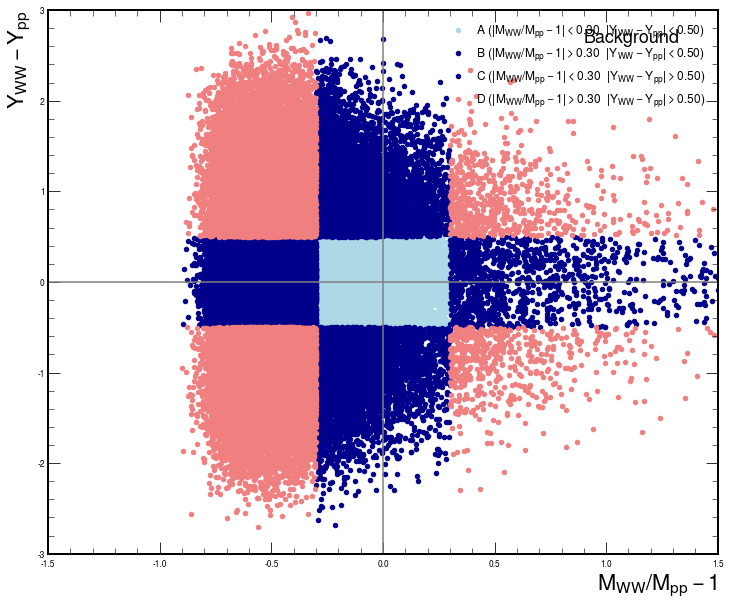

In [31]:
msk_bkg_cut1 = ( np.abs( df_protons_multiRP_bkg_events[ "shiftedRatioMWW_MX" ] ) <= 0.30 )
msk_bkg_cut2 = ( np.abs( df_protons_multiRP_bkg_events[ "diffYWW_YX" ] ) <= 0.50 )
msk_bkg_A =  msk_bkg_cut1 &  msk_bkg_cut2
msk_bkg_B = ~msk_bkg_cut1 &  msk_bkg_cut2
msk_bkg_C =  msk_bkg_cut1 & ~msk_bkg_cut2
msk_bkg_D = ~msk_bkg_cut1 & ~msk_bkg_cut2

n_events_bkg   = np.sum( df_protons_multiRP_bkg_events[ "norm" ] )
n_events_bkg_A = np.sum( df_protons_multiRP_bkg_events[ msk_bkg_A ][ "norm" ] )
n_events_bkg_B = np.sum( df_protons_multiRP_bkg_events[ msk_bkg_B ][ "norm" ] )
n_events_bkg_C = np.sum( df_protons_multiRP_bkg_events[ msk_bkg_C ][ "norm" ] )
n_events_bkg_D = np.sum( df_protons_multiRP_bkg_events[ msk_bkg_D ][ "norm" ] )

print ( "Number of events: {}".format( n_events_bkg ) )
print ( "Number of events (A): {}".format( n_events_bkg_A ) )
print ( "Number of events (B): {}".format( n_events_bkg_B ) )
print ( "Number of events (C): {}".format( n_events_bkg_C ) )
print ( "Number of events (D): {}".format( n_events_bkg_D ) )

x_min = -1.5
x_max =  1.5
y_min = -3.0
y_max =  3.0
x_center = ( x_min + x_max ) / 2.
y_center = ( y_min + y_max ) / 2.

fig = plt.figure( figsize=(12,10) )
plt.plot( (x_min,x_max), (y_center,y_center), color='gray' )
plt.plot( (x_center,x_center), (y_min,y_max), color='gray' )
ax = plt.gca()
label_str_ = r"A ($|M_{WW} / M_{pp} - 1| < 0.30$  $|Y_{WW} - Y_{pp}| < 0.50$)"
df_protons_multiRP_bkg_events[ msk_bkg_A ].plot( "shiftedRatioMWW_MX", "diffYWW_YX", 'scatter', ax=ax, color='lightblue', label=label_str_ )
label_str_ = r"B ($|M_{WW} / M_{pp} - 1| > 0.30$  $|Y_{WW} - Y_{pp}| < 0.50$)"
df_protons_multiRP_bkg_events[ msk_bkg_B ].plot( "shiftedRatioMWW_MX", "diffYWW_YX", 'scatter', ax=ax, color='darkblue', label=label_str_ )
label_str_ = r"C ($|M_{WW} / M_{pp} - 1| < 0.30$  $|Y_{WW} - Y_{pp}| > 0.50$)"
df_protons_multiRP_bkg_events[ msk_bkg_C ].plot( "shiftedRatioMWW_MX", "diffYWW_YX", 'scatter', ax=ax, color='darkblue', label=label_str_ )
label_str_ = r"D ($|M_{WW} / M_{pp} - 1| > 0.30$  $|Y_{WW} - Y_{pp}| > 0.50$)"
df_protons_multiRP_bkg_events[ msk_bkg_D ].plot( "shiftedRatioMWW_MX", "diffYWW_YX", 'scatter', ax=ax, color='lightcoral', label=label_str_ )
plt.legend( loc='best', fontsize=12 )
ax.text( 0.80, 0.95, "Background", horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=18 )
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xlabel( r"$M_{WW} / M_{pp} - 1$", fontsize=22 )
plt.ylabel( r"$Y_{WW} - Y_{pp}$", fontsize=22 )
if save_figures:
    plt.savefig( "plots/ANN-Keras_Mass_Rapidity_Difference_2D_Background_test-multiRP_2021_01_22-17_46_10.pdf", bbox_inches='tight' )
    plt.savefig( "plots/ANN-Keras_Mass_Rapidity_Difference_2D_Background_test-multiRP_2021_01_22-17_46_10.png", bbox_inches='tight' )

Number of events: 9086.375
Number of events (A): 960.125
Number of events (B): 2523.625
Number of events (C): 1425.375
Number of events (D): 4177.25


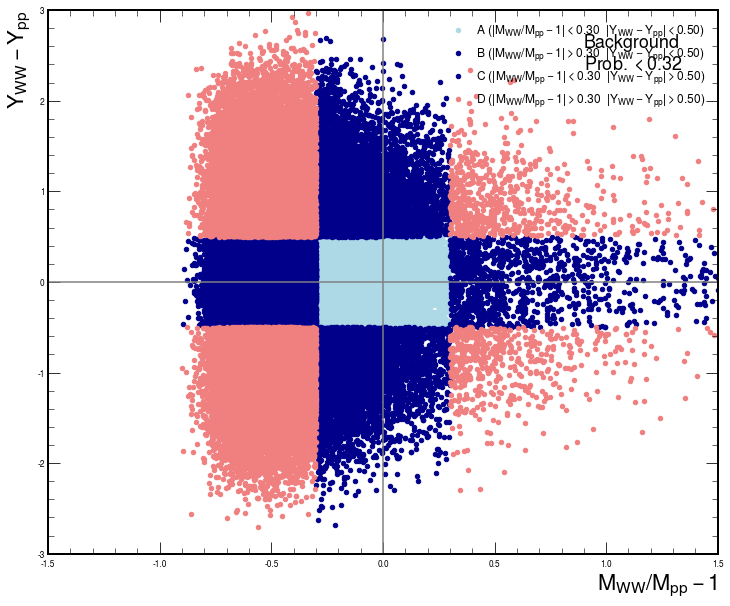

In [32]:
msk_bkg_cut1 = ( np.abs( df_protons_multiRP_bkg_events_bkgreg[ "shiftedRatioMWW_MX" ] ) <= 0.30 )
msk_bkg_cut2 = ( np.abs( df_protons_multiRP_bkg_events_bkgreg[ "diffYWW_YX" ] ) <= 0.50 )
msk_bkg_A =  msk_bkg_cut1 &  msk_bkg_cut2
msk_bkg_B = ~msk_bkg_cut1 &  msk_bkg_cut2
msk_bkg_C =  msk_bkg_cut1 & ~msk_bkg_cut2
msk_bkg_D = ~msk_bkg_cut1 & ~msk_bkg_cut2

n_events_bkg_bkgreg   = np.sum( df_protons_multiRP_bkg_events_bkgreg[ "norm" ] )
n_events_bkg_bkgreg_A = np.sum( df_protons_multiRP_bkg_events_bkgreg[ msk_bkg_A ][ "norm" ] )
n_events_bkg_bkgreg_B = np.sum( df_protons_multiRP_bkg_events_bkgreg[ msk_bkg_B ][ "norm" ] )
n_events_bkg_bkgreg_C = np.sum( df_protons_multiRP_bkg_events_bkgreg[ msk_bkg_C ][ "norm" ] )
n_events_bkg_bkgreg_D = np.sum( df_protons_multiRP_bkg_events_bkgreg[ msk_bkg_D ][ "norm" ] )

print ( "Number of events: {}".format( n_events_bkg_bkgreg ) )
print ( "Number of events (A): {}".format( n_events_bkg_bkgreg_A ) )
print ( "Number of events (B): {}".format( n_events_bkg_bkgreg_B ) )
print ( "Number of events (C): {}".format( n_events_bkg_bkgreg_C ) )
print ( "Number of events (D): {}".format( n_events_bkg_bkgreg_D ) )

x_min = -1.5
x_max =  1.5
y_min = -3.0
y_max =  3.0
x_center = ( x_min + x_max ) / 2.
y_center = ( y_min + y_max ) / 2.

fig = plt.figure( figsize=(12,10) )
plt.plot( (x_min,x_max), (y_center,y_center), color='gray' )
plt.plot( (x_center,x_center), (y_min,y_max), color='gray' )
ax = plt.gca()
label_str_ = r"A ($|M_{WW} / M_{pp} - 1| < 0.30$  $|Y_{WW} - Y_{pp}| < 0.50$)"
df_protons_multiRP_bkg_events_bkgreg[ msk_bkg_A ].plot( "shiftedRatioMWW_MX", "diffYWW_YX", 'scatter', ax=ax, color='lightblue', label=label_str_ )
label_str_ = r"B ($|M_{WW} / M_{pp} - 1| > 0.30$  $|Y_{WW} - Y_{pp}| < 0.50$)"
df_protons_multiRP_bkg_events_bkgreg[ msk_bkg_B ].plot( "shiftedRatioMWW_MX", "diffYWW_YX", 'scatter', ax=ax, color='darkblue', label=label_str_ )
label_str_ = r"C ($|M_{WW} / M_{pp} - 1| < 0.30$  $|Y_{WW} - Y_{pp}| > 0.50$)"
df_protons_multiRP_bkg_events_bkgreg[ msk_bkg_C ].plot( "shiftedRatioMWW_MX", "diffYWW_YX", 'scatter', ax=ax, color='darkblue', label=label_str_ )
label_str_ = r"D ($|M_{WW} / M_{pp} - 1| > 0.30$  $|Y_{WW} - Y_{pp}| > 0.50$)"
df_protons_multiRP_bkg_events_bkgreg[ msk_bkg_D ].plot( "shiftedRatioMWW_MX", "diffYWW_YX", 'scatter', ax=ax, color='lightcoral', label=label_str_ )
plt.legend( loc='best', fontsize=12 )
title_str_ = "Background\n$\\rm{{Prob.}} < {:.2f}$".format( prob_cut )
title_str_ = r"{}".format( title_str_ )
ax.text( 0.80, 0.92, title_str_, horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=18 )
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xlabel( r"$M_{WW} / M_{pp} - 1$", fontsize=22 )
plt.ylabel( r"$Y_{WW} - Y_{pp}$", fontsize=22 )
if save_figures:
    plt.savefig( "plots/ANN-Keras_Mass_Rapidity_Difference_2D_Background_Bkg_Region_90pct_Point_Cut_test-multiRP_2021_01_22-17_46_10.pdf", bbox_inches='tight' )
    plt.savefig( "plots/ANN-Keras_Mass_Rapidity_Difference_2D_Background_Bkg_Region_90pct_Point_Cut_test-multiRP_2021_01_22-17_46_10.png", bbox_inches='tight' )

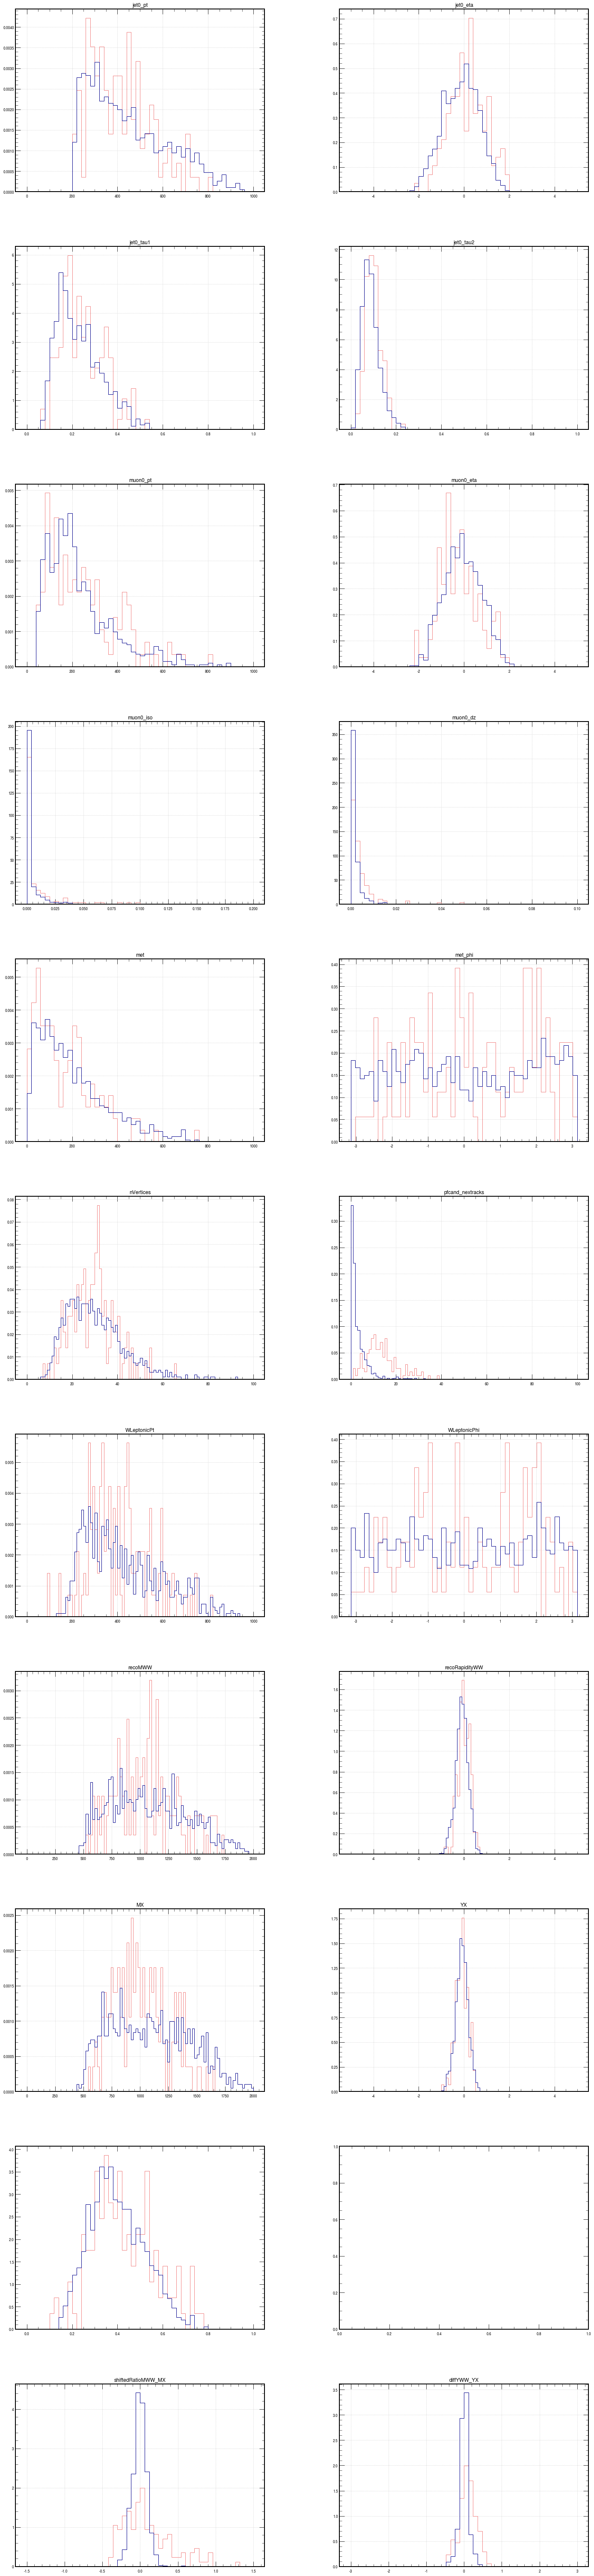

In [33]:
label_signal = "GGToWW-AQGC-A0W1e-6"

fig, axes = plt.subplots( 11, 2, figsize=(24,11*10) )

row_ = 0
df_protons_multiRP_bkg_events_sigreg.hist( "jet0_pt", bins=50, range=(0.,1000.), histtype="step", density=True, color="lightcoral", ax=axes[row_,0] )
df_signals_protons_multiRP_events_sigreg[ label_signal ].hist( "jet0_pt", bins=50, range=(0.,1000.), histtype="step", density=True, color="darkblue", ax=axes[row_,0] )

df_protons_multiRP_bkg_events_sigreg.hist( "jet0_eta", bins=50, range=(-5.,5.), histtype="step", density=True, color="lightcoral", ax=axes[row_,1] )
df_signals_protons_multiRP_events_sigreg[ label_signal ].hist( "jet0_eta", bins=50, range=(-5.,5.), histtype="step", density=True, color="darkblue", ax=axes[row_,1] )
row_ += 1

df_protons_multiRP_bkg_events_sigreg.hist( "jet0_tau1", bins=50, range=(0.,1.), histtype="step", density=True, color="lightcoral", ax=axes[row_,0] )
df_signals_protons_multiRP_events_sigreg[ label_signal ].hist( "jet0_tau1", bins=50, range=(0.,1.), histtype="step", density=True, color="darkblue", ax=axes[row_,0] )

df_protons_multiRP_bkg_events_sigreg.hist( "jet0_tau2", bins=50, range=(0.,1.), histtype="step", density=True, color="lightcoral", ax=axes[row_,1] )
df_signals_protons_multiRP_events_sigreg[ label_signal ].hist( "jet0_tau2", bins=50, range=(0.,1.), histtype="step", density=True, color="darkblue", ax=axes[row_,1] )
row_ += 1

df_protons_multiRP_bkg_events_sigreg.hist( "muon0_pt", bins=50, range=(0.,1000.), histtype="step", density=True, color="lightcoral", ax=axes[row_,0] )
df_signals_protons_multiRP_events_sigreg[ label_signal ].hist( "muon0_pt", bins=50, range=(0.,1000.), histtype="step", density=True, color="darkblue", ax=axes[row_,0] )

df_protons_multiRP_bkg_events_sigreg.hist( "muon0_eta", bins=50, range=(-5.,5.), histtype="step", density=True, color="lightcoral", ax=axes[row_,1] )
df_signals_protons_multiRP_events_sigreg[ label_signal ].hist( "muon0_eta", bins=50, range=(-5.,5.), histtype="step", density=True, color="darkblue", ax=axes[row_,1] )
row_ += 1

df_protons_multiRP_bkg_events_sigreg.hist( "muon0_iso", bins=50, range=(0.,0.2), histtype="step", density=True, color="lightcoral", ax=axes[row_,0] )
df_signals_protons_multiRP_events_sigreg[ label_signal ].hist( "muon0_iso", bins=50, range=(0.,0.2), histtype="step", density=True, color="darkblue", ax=axes[row_,0] )

df_protons_multiRP_bkg_events_sigreg.hist( "muon0_dz", bins=50, range=(0.,0.1), histtype="step", density=True, color="lightcoral", ax=axes[row_,1] )
df_signals_protons_multiRP_events_sigreg[ label_signal ].hist( "muon0_dz", bins=50, range=(0.,0.1), histtype="step", density=True, color="darkblue", ax=axes[row_,1] )
row_ += 1

df_protons_multiRP_bkg_events_sigreg.hist( "met", bins=50, range=(0.,1000.), histtype="step", density=True, color="lightcoral", ax=axes[row_,0] )
df_signals_protons_multiRP_events_sigreg[ label_signal ].hist( "met", bins=50, range=(0.,1000.), histtype="step", density=True, color="darkblue", ax=axes[row_,0] )

df_protons_multiRP_bkg_events_sigreg.hist( "met_phi", bins=50, range=(-np.pi,np.pi), histtype="step", density=True, color="lightcoral", ax=axes[row_,1] )
df_signals_protons_multiRP_events_sigreg[ label_signal ].hist( "met_phi", bins=50, range=(-np.pi,np.pi), histtype="step", density=True, color="darkblue", ax=axes[row_,1] )
row_ += 1

df_protons_multiRP_bkg_events_sigreg.hist( "nVertices", bins=100, range=(0.,100.), histtype="step", density=True, color="lightcoral", ax=axes[row_,0] )
df_signals_protons_multiRP_events_sigreg[ label_signal ].hist( "nVertices", bins=100, range=(0.,100.), histtype="step", density=True, color="darkblue", ax=axes[row_,0] )

df_protons_multiRP_bkg_events_sigreg.hist( "pfcand_nextracks", bins=100, range=(0.,100.), histtype="step", density=True, color="lightcoral", ax=axes[row_,1] )
df_signals_protons_multiRP_events_sigreg[ label_signal ].hist( "pfcand_nextracks", bins=100, range=(0.,100.), histtype="step", density=True, color="darkblue", ax=axes[row_,1] )
row_ += 1

df_protons_multiRP_bkg_events_sigreg.hist( "WLeptonicPt", bins=100, range=(0.,1000.), histtype="step", density=True, color="lightcoral", ax=axes[row_,0] )
df_signals_protons_multiRP_events_sigreg[ label_signal ].hist( "WLeptonicPt", bins=100, range=(0.,1000.), histtype="step", density=True, color="darkblue", ax=axes[row_,0] )

df_protons_multiRP_bkg_events_sigreg.hist( "WLeptonicPhi", bins=50, range=(-np.pi,np.pi), histtype="step", density=True, color="lightcoral", ax=axes[row_,1] )
df_signals_protons_multiRP_events_sigreg[ label_signal ].hist( "WLeptonicPhi", bins=50, range=(-np.pi,np.pi), histtype="step", density=True, color="darkblue", ax=axes[row_,1] )
row_ += 1

df_protons_multiRP_bkg_events_sigreg.hist( "recoMWW", bins=100, range=(0.,2000.), histtype="step", density=True, color="lightcoral", ax=axes[row_,0] )
df_signals_protons_multiRP_events_sigreg[ label_signal ].hist( "recoMWW", bins=100, range=(0.,2000.), histtype="step", density=True, color="darkblue", ax=axes[row_,0] )

df_protons_multiRP_bkg_events_sigreg.hist( "recoRapidityWW", bins=100, range=(-5.,5.), histtype="step", density=True, color="lightcoral", ax=axes[row_,1] )
df_signals_protons_multiRP_events_sigreg[ label_signal ].hist( "recoRapidityWW", bins=100, range=(-5.,5.), histtype="step", density=True, color="darkblue", ax=axes[row_,1] )
row_ += 1

df_protons_multiRP_bkg_events_sigreg.hist( "MX", bins=100, range=(0.,2000.), histtype="step", density=True, color="lightcoral", ax=axes[row_,0] )
df_signals_protons_multiRP_events_sigreg[ label_signal ].hist( "MX", bins=100, range=(0.,2000.), histtype="step", density=True, color="darkblue", ax=axes[row_,0] )

df_protons_multiRP_bkg_events_sigreg.hist( "YX", bins=100, range=(-5.,5.), histtype="step", density=True, color="lightcoral", ax=axes[row_,1] )
df_signals_protons_multiRP_events_sigreg[ label_signal ].hist( "YX", bins=100, range=(-5.,5.), histtype="step", density=True, color="darkblue", ax=axes[row_,1] )
row_ += 1

axes[row_,0].hist( ( df_protons_multiRP_bkg_events_sigreg[ "jet0_tau2" ] / df_protons_multiRP_bkg_events_sigreg[ "jet0_tau1" ] ), bins=50, range=(0.,1.), histtype="step", density=True, color="lightcoral" )
axes[row_,0].hist( ( df_signals_protons_multiRP_events_sigreg[ label_signal ][ "jet0_tau2" ] / df_signals_protons_multiRP_events_sigreg[ label_signal ][ "jet0_tau1" ] ), bins=50, range=(0.,1.), histtype="step", density=True, color="darkblue" )
row_ += 1

df_protons_multiRP_bkg_events_sigreg.hist( "shiftedRatioMWW_MX", bins=50, range=(-1.5,1.5), histtype="step", density=True, color="lightcoral", ax=axes[row_,0] )
df_signals_protons_multiRP_events_sigreg[ label_signal ].hist( "shiftedRatioMWW_MX", bins=50, range=(-1.5,1.5), histtype="step", density=True, color="darkblue", ax=axes[row_,0] )

df_protons_multiRP_bkg_events_sigreg.hist( "diffYWW_YX", bins=50, range=(-3.,3.), histtype="step", density=True, color="lightcoral", ax=axes[row_,1] )
df_signals_protons_multiRP_events_sigreg[ label_signal ].hist( "diffYWW_YX", bins=50, range=(-3.,3.), histtype="step", density=True, color="darkblue", ax=axes[row_,1] )
row_ += 1


Number of events: 17.75 +/- 1.489546910976623
Number of events (A): 11.75 +/- 1.2119199643540823
Number of events (B): 5.25 +/- 0.8100925873009825
Number of events (C): 0.5 +/- 0.25
Number of events (D): 0.25 +/- 0.1767766952966369


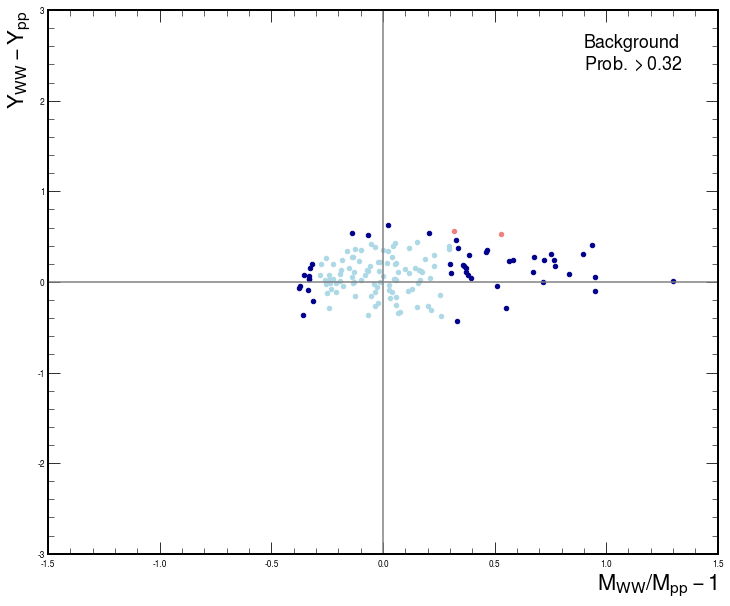

In [34]:
msk_bkg_cut1 = ( np.abs( df_protons_multiRP_bkg_events_sigreg[ "shiftedRatioMWW_MX" ] ) <= 0.30 )
msk_bkg_cut2 = ( np.abs( df_protons_multiRP_bkg_events_sigreg[ "diffYWW_YX" ] ) <= 0.50 )
msk_bkg_A =  msk_bkg_cut1 &  msk_bkg_cut2
msk_bkg_B = ~msk_bkg_cut1 &  msk_bkg_cut2
msk_bkg_C =  msk_bkg_cut1 & ~msk_bkg_cut2
msk_bkg_D = ~msk_bkg_cut1 & ~msk_bkg_cut2

n_events_bkg_sigreg   = np.sum( df_protons_multiRP_bkg_events_sigreg[ "norm" ] )
err_n_events_bkg_sigreg = np.sqrt( np.sum( np.square( df_protons_multiRP_bkg_events_sigreg[ "norm" ] ) ) )
n_events_bkg_sigreg_A = np.sum( df_protons_multiRP_bkg_events_sigreg[ msk_bkg_A ][ "norm" ] )
err_n_events_bkg_sigreg_A = np.sqrt( np.sum( np.square( df_protons_multiRP_bkg_events_sigreg[ msk_bkg_A ][ "norm" ] ) ) )
n_events_bkg_sigreg_B = np.sum( df_protons_multiRP_bkg_events_sigreg[ msk_bkg_B ][ "norm" ] )
err_n_events_bkg_sigreg_B = np.sqrt( np.sum( np.square( df_protons_multiRP_bkg_events_sigreg[ msk_bkg_B ][ "norm" ] ) ) )
n_events_bkg_sigreg_C = np.sum( df_protons_multiRP_bkg_events_sigreg[ msk_bkg_C ][ "norm" ] )
err_n_events_bkg_sigreg_C = np.sqrt( np.sum( np.square( df_protons_multiRP_bkg_events_sigreg[ msk_bkg_C ][ "norm" ] ) ) )
n_events_bkg_sigreg_D = np.sum( df_protons_multiRP_bkg_events_sigreg[ msk_bkg_D ][ "norm" ] )
err_n_events_bkg_sigreg_D = np.sqrt( np.sum( np.square( df_protons_multiRP_bkg_events_sigreg[ msk_bkg_D ][ "norm" ] ) ) )

print ( "Number of events: {} +/- {}".format( n_events_bkg_sigreg, err_n_events_bkg_sigreg ) )
print ( "Number of events (A): {} +/- {}".format( n_events_bkg_sigreg_A, err_n_events_bkg_sigreg_A ) )
print ( "Number of events (B): {} +/- {}".format( n_events_bkg_sigreg_B, err_n_events_bkg_sigreg_B ) )
print ( "Number of events (C): {} +/- {}".format( n_events_bkg_sigreg_C, err_n_events_bkg_sigreg_C ) )
print ( "Number of events (D): {} +/- {}".format( n_events_bkg_sigreg_D, err_n_events_bkg_sigreg_D ) )

x_min = -1.5
x_max =  1.5
y_min = -3.0
y_max =  3.0
x_center = ( x_min + x_max ) / 2.
y_center = ( y_min + y_max ) / 2.

fig = plt.figure( figsize=(12,10) )
plt.plot( (x_min,x_max), (y_center,y_center), color='gray' )
plt.plot( (x_center,x_center), (y_min,y_max), color='gray' )
ax = plt.gca()
if np.sum( msk_bkg_A ) > 0:
    df_protons_multiRP_bkg_events_sigreg[ msk_bkg_A ].plot( "shiftedRatioMWW_MX", "diffYWW_YX", 'scatter', ax=ax, color='lightblue' )
if np.sum( msk_bkg_B ) > 0:
    df_protons_multiRP_bkg_events_sigreg[ msk_bkg_B ].plot( "shiftedRatioMWW_MX", "diffYWW_YX", 'scatter', ax=ax, color='darkblue' )
if np.sum( msk_bkg_C ) > 0:
    df_protons_multiRP_bkg_events_sigreg[ msk_bkg_C ].plot( "shiftedRatioMWW_MX", "diffYWW_YX", 'scatter', ax=ax, color='darkblue' )
if np.sum( msk_bkg_D ) > 0:
    df_protons_multiRP_bkg_events_sigreg[ msk_bkg_D ].plot( "shiftedRatioMWW_MX", "diffYWW_YX", 'scatter', ax=ax, color='lightcoral' )
title_str_ = "Background\n$\\rm{{Prob.}} > {:.2f}$".format( prob_cut )
title_str_ = r"{}".format( title_str_ )
ax.text( 0.80, 0.92, title_str_, horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=18 )
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xlabel( r"$M_{WW} / M_{pp} - 1$", fontsize=22 )
plt.ylabel( r"$Y_{WW} - Y_{pp}$", fontsize=22 )
if save_figures:
    plt.savefig( "plots/ANN-Keras_Mass_Rapidity_Difference_2D_Background_Sig_Region_90pct_Point_Cut_test-multiRP_2021_01_22-17_46_10.pdf", bbox_inches='tight' )
    plt.savefig( "plots/ANN-Keras_Mass_Rapidity_Difference_2D_Background_Sig_Region_90pct_Point_Cut_test-multiRP_2021_01_22-17_46_10.png", bbox_inches='tight' )

GGToWW-AQGC-A0W1e-6
Number of events: 4.052241394033102 +/- 0.018020006259988643
Number of events (A): 4.0437461290560925 +/- 0.018006717983092297
Number of events (B): 0.008495264977008596 +/- 0.0006919054035129014
Number of events (C): 0.0 +/- 0.0
Number of events (D): 0.0 +/- 0.0
0 0


/cvmfs/sft.cern.ch/lcg/views/LCG_99/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/pandas/plotting/_tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/cvmfs/sft.cern.ch/lcg/views/LCG_99/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/pandas/plotting/_tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/cvmfs/sft.cern.ch/lcg/views/LCG_99/x86_64-centos7-gcc8-opt/lib/python3.8/site-packages/pandas/plotting/_tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if n

GGToWW-AQGC-A0W2e-6
Number of events: 10.813142579776859 +/- 0.037115881474231296
Number of events (A): 10.7823359057604 +/- 0.03706171995921728
Number of events (B): 0.024645339213166625 +/- 0.001714510198430283
Number of events (C): 0.006161334803291656 +/- 0.0010382803346012939
Number of events (D): 0.0 +/- 0.0
0 1
GGToWW-AQGC-A0W5e-6
Number of events: 59.43218638235679 +/- 0.13458008114240666
Number of events (A): 59.16865976829266 +/- 0.13428837204642602
Number of events (B): 0.24965679227127704 +/- 0.008604937482806404
Number of events (C): 0.0 +/- 0.0
Number of events (D): 0.013869821792848723 +/- 0.002094379224118515
1 0


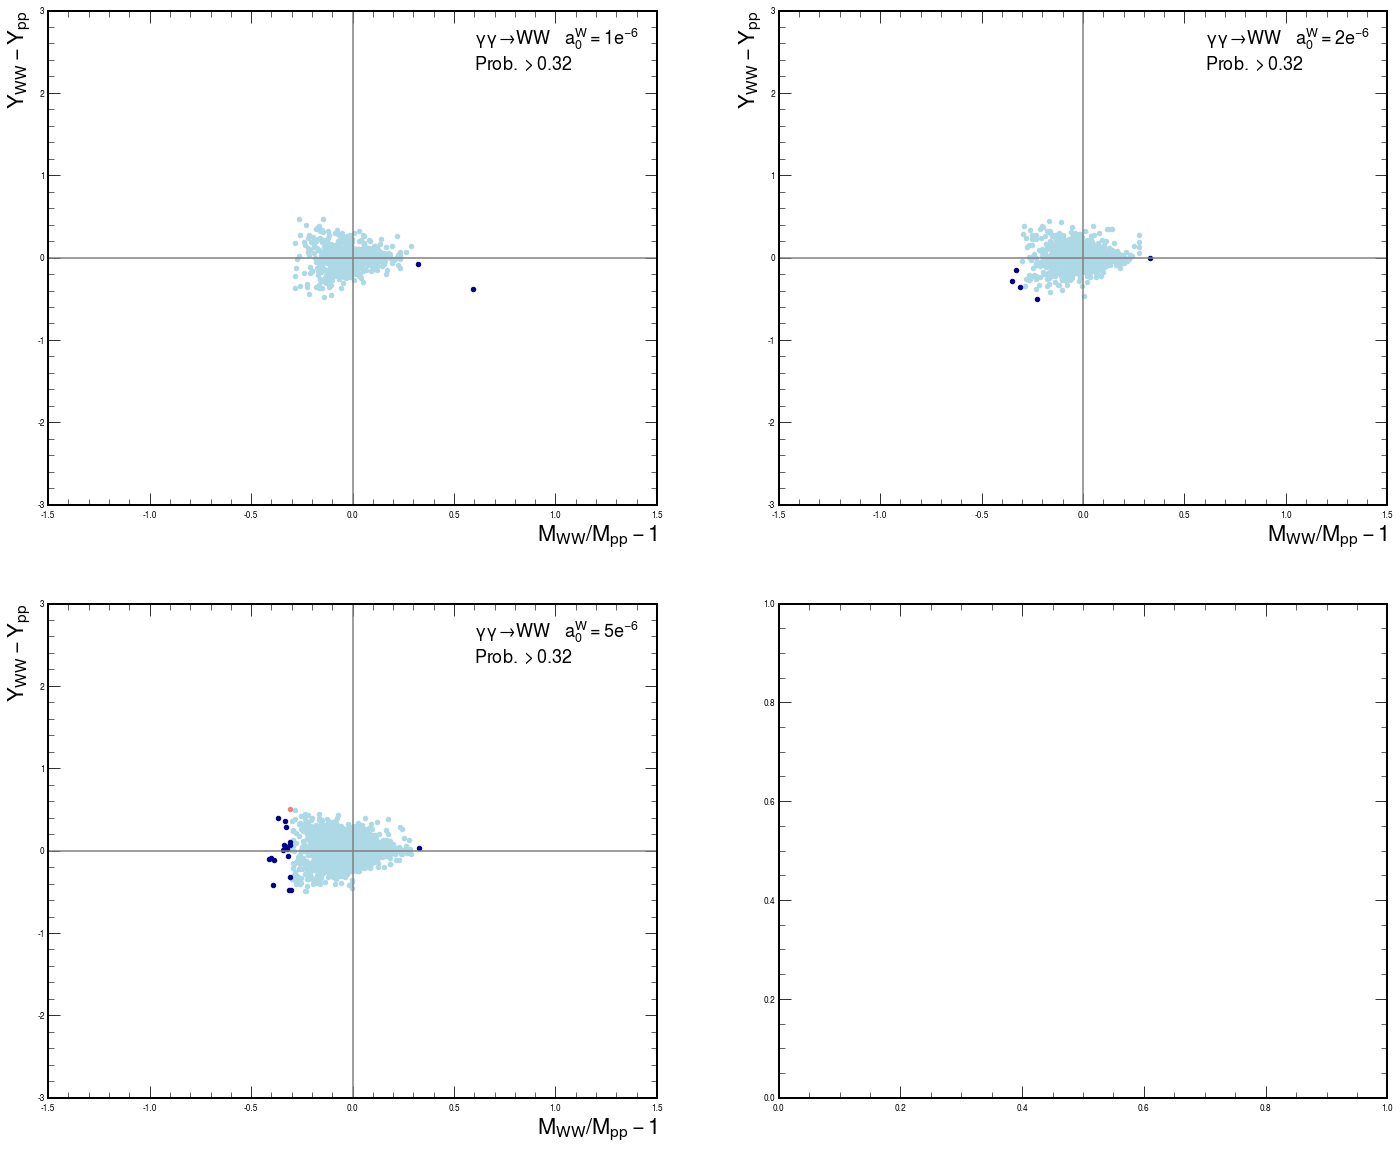

In [35]:
#label_signal = "GGToWW-AQGC-test-A0W5e-6"

nrows_ = ( int( len(labels_signals)/2 ) + 1 if ( len(labels_signals) % 2 ) > 0 else  int( len(labels_signals)/2 ) )
fig, axes = plt.subplots( nrows_, 2, figsize=(24,nrows_*10) )

row_ = 0
col_ = 0
for label_ in labels_signals:
    print ( label_ )
    
    msk_sig_cut1 = ( np.abs( df_signals_protons_multiRP_events_sigreg[ label_ ][ "shiftedRatioMWW_MX" ] ) <= 0.30 )
    msk_sig_cut2 = ( np.abs( df_signals_protons_multiRP_events_sigreg[ label_ ][ "diffYWW_YX" ] ) <= 0.50 )
    msk_sig_A =  msk_sig_cut1 &  msk_sig_cut2
    msk_sig_B = ~msk_sig_cut1 &  msk_sig_cut2
    msk_sig_C =  msk_sig_cut1 & ~msk_sig_cut2
    msk_sig_D = ~msk_sig_cut1 & ~msk_sig_cut2

    n_events_sig   = np.sum( df_signals_protons_multiRP_events_sigreg[ label_ ][ "norm" ] *
                             df_signals_protons_multiRP_events_sigreg[ label_ ]["eff_all_weighted"] )
    err_n_events_sig = np.sqrt( np.sum( np.square( df_signals_protons_multiRP_events_sigreg[ label_ ][ "norm" ] *
                                                   df_signals_protons_multiRP_events_sigreg[ label_ ]["eff_all_weighted"] ) ) )
    n_events_sig_A = np.sum( df_signals_protons_multiRP_events_sigreg[ label_ ][ msk_sig_A ][ "norm" ] *
                             df_signals_protons_multiRP_events_sigreg[ label_ ][ msk_sig_A ]["eff_all_weighted"] )
    err_n_events_sig_A = np.sqrt( np.sum( np.square( df_signals_protons_multiRP_events_sigreg[ label_ ][ msk_sig_A ][ "norm" ] *
                                                     df_signals_protons_multiRP_events_sigreg[ label_ ][ msk_sig_A ]["eff_all_weighted"] ) ) )
    n_events_sig_B = np.sum( df_signals_protons_multiRP_events_sigreg[ label_ ][ msk_sig_B ][ "norm" ] *
                             df_signals_protons_multiRP_events_sigreg[ label_ ][ msk_sig_B ]["eff_all_weighted"] )
    err_n_events_sig_B = np.sqrt( np.sum( np.square( df_signals_protons_multiRP_events_sigreg[ label_ ][ msk_sig_B ][ "norm" ] *
                                                     df_signals_protons_multiRP_events_sigreg[ label_ ][ msk_sig_B ]["eff_all_weighted"] ) ) )
    n_events_sig_C = np.sum( df_signals_protons_multiRP_events_sigreg[ label_ ][ msk_sig_C ][ "norm" ] *
                             df_signals_protons_multiRP_events_sigreg[ label_ ][ msk_sig_C ]["eff_all_weighted"] )
    err_n_events_sig_C = np.sqrt( np.sum( np.square( df_signals_protons_multiRP_events_sigreg[ label_ ][ msk_sig_C ][ "norm" ] *
                                                     df_signals_protons_multiRP_events_sigreg[ label_ ][ msk_sig_C ]["eff_all_weighted"] ) ) )
    n_events_sig_D = np.sum( df_signals_protons_multiRP_events_sigreg[ label_ ][ msk_sig_D ][ "norm" ] *
                             df_signals_protons_multiRP_events_sigreg[ label_ ][ msk_sig_D ]["eff_all_weighted"] )
    err_n_events_sig_D = np.sqrt( np.sum( np.square( df_signals_protons_multiRP_events_sigreg[ label_ ][ msk_sig_D ][ "norm" ] *
                                                     df_signals_protons_multiRP_events_sigreg[ label_ ][ msk_sig_D ]["eff_all_weighted"] ) ) )

    print ( "Number of events: {} +/- {}".format( n_events_sig, err_n_events_sig ) )
    print ( "Number of events (A): {} +/- {}".format( n_events_sig_A, err_n_events_sig_A ) )
    print ( "Number of events (B): {} +/- {}".format( n_events_sig_B, err_n_events_sig_B ) )
    print ( "Number of events (C): {} +/- {}".format( n_events_sig_C, err_n_events_sig_C ) )
    print ( "Number of events (D): {} +/- {}".format( n_events_sig_D, err_n_events_sig_D ) )

    x_min = -1.5
    x_max =  1.5
    y_min = -3.0
    y_max =  3.0
    x_center = ( x_min + x_max ) / 2.
    y_center = ( y_min + y_max ) / 2.

    print ( row_, col_ )
    axes[ row_, col_ ].plot( (x_min,x_max), (y_center,y_center), color='gray' )
    axes[ row_, col_ ].plot( (x_center,x_center), (y_min,y_max), color='gray' )
    if np.sum( msk_sig_A ) > 0:
        df_signals_protons_multiRP_events_sigreg[ label_ ][ msk_sig_A ].plot( "shiftedRatioMWW_MX", "diffYWW_YX", 'scatter', ax=axes[ row_, col_ ], color='lightblue' )
    if np.sum( msk_sig_B ) > 0:
        df_signals_protons_multiRP_events_sigreg[ label_ ][ msk_sig_B ].plot( "shiftedRatioMWW_MX", "diffYWW_YX", 'scatter', ax=axes[ row_, col_ ], color='darkblue' )
    if np.sum( msk_sig_C ) > 0:
        df_signals_protons_multiRP_events_sigreg[ label_ ][ msk_sig_C ].plot( "shiftedRatioMWW_MX", "diffYWW_YX", 'scatter', ax=axes[ row_, col_ ], color='darkblue' )
    if np.sum( msk_sig_D ) > 0:
        df_signals_protons_multiRP_events_sigreg[ label_ ][ msk_sig_D ].plot( "shiftedRatioMWW_MX", "diffYWW_YX", 'scatter', ax=axes[ row_, col_ ], color='lightcoral' )
    title_str_ = "{}\n$\\rm{{Prob.}} > {:.2f}$".format( labels_samples[ label_ ], prob_cut )
    title_str_ = r"{}".format( title_str_ )
    axes[ row_, col_ ].text( 0.70, 0.92, title_str_, horizontalalignment='left', verticalalignment='center', transform=axes[ row_, col_ ].transAxes, fontsize=18 )
    axes[ row_, col_ ].set_xlim(x_min, x_max)
    axes[ row_, col_ ].set_ylim(y_min, y_max)
    axes[ row_, col_ ].set_xlabel( r"$M_{WW} / M_{pp} - 1$", fontsize=22 )
    axes[ row_, col_ ].set_ylabel( r"$Y_{WW} - Y_{pp}$", fontsize=22 )
    col_ += 1
    if col_ >= 2:
        row_ += 1
        col_  = 0

if save_figures:        
    plt.savefig( "plots/ANN-Keras_Mass_Rapidity_Difference_2D_Signals_Sig_Region_90pct_Point_Cut_test-multiRP_2021_01_22-17_46_10.pdf", bbox_inches='tight' )
    plt.savefig( "plots/ANN-Keras_Mass_Rapidity_Difference_2D_Signals_Sig_Region_90pct_Point_Cut_test-multiRP_2021_01_22-17_46_10.png", bbox_inches='tight' )

Text(0, 1, '$Y_{WW} - Y_{pp}$')

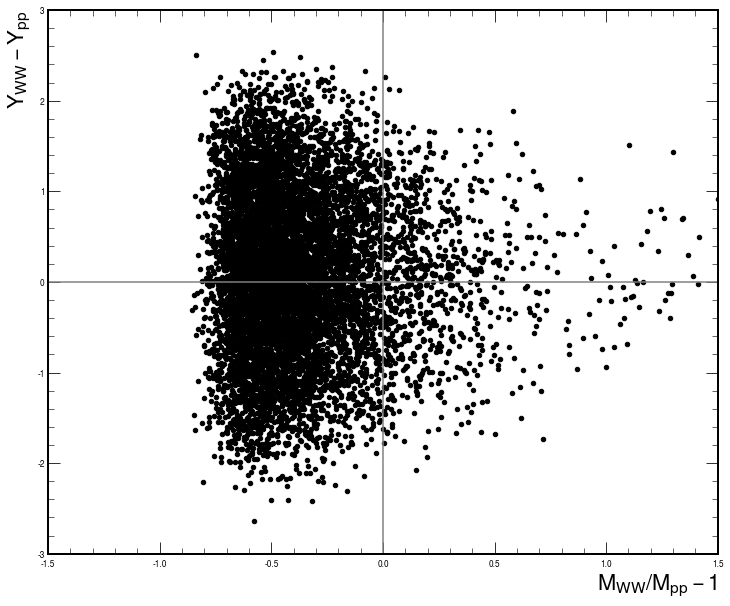

In [36]:
x_min = -1.5
x_max =  1.5
y_min = -3.0
y_max =  3.0
x_center = ( x_min + x_max ) / 2.
y_center = ( y_min + y_max ) / 2.

fig = plt.figure( figsize=(12,10) )
plt.plot( (x_min,x_max), (y_center,y_center), color='gray' )
plt.plot( (x_center,x_center), (y_min,y_max), color='gray' )
ax = plt.gca()
df_protons_multiRP_data_events_bkgreg.plot( "shiftedRatioMWW_MX", "diffYWW_YX", 'scatter', ax=ax, color='black' )
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xlabel( r"$M_{WW} / M_{pp} - 1$", fontsize=22 )
plt.ylabel( r"$Y_{WW} - Y_{pp}$", fontsize=22 )

Number of events: 8852 - Ratio: 0.9742058851852361
Number of events (A): 1011 - Ratio: 1.0529878922015363
Number of events (B): 2458 - Ratio: 0.9739957402545941
Number of events (C): 1394 - Ratio: 0.9779882487064807
Number of events (D): 3989 - Ratio: 0.9549344664552037


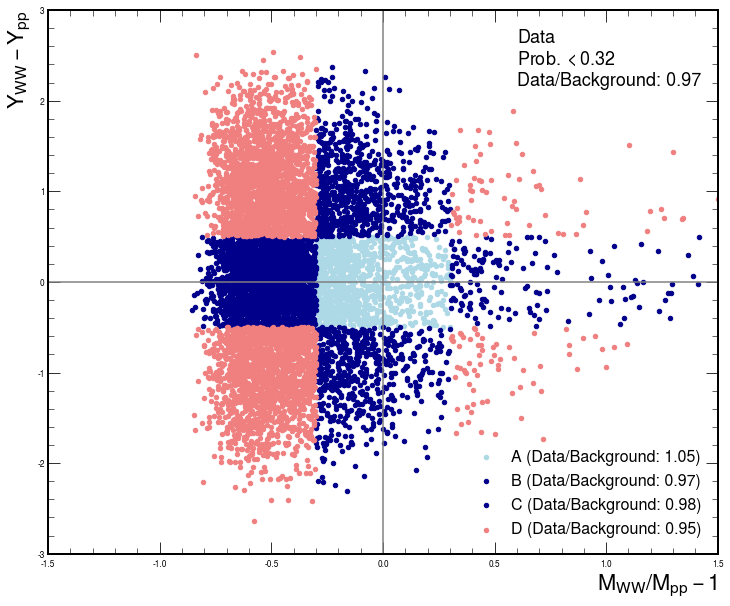

In [37]:
msk_data_cut1 = ( np.abs( df_protons_multiRP_data_events_bkgreg[ "shiftedRatioMWW_MX" ] ) <= 0.30 )
msk_data_cut2 = ( np.abs( df_protons_multiRP_data_events_bkgreg[ "diffYWW_YX" ] ) <= 0.50 )
msk_data_A =  msk_data_cut1 &  msk_data_cut2
msk_data_B = ~msk_data_cut1 &  msk_data_cut2
msk_data_C =  msk_data_cut1 & ~msk_data_cut2
msk_data_D = ~msk_data_cut1 & ~msk_data_cut2

n_events_data_bkgreg = df_protons_multiRP_data_events_bkgreg.shape[0]
n_events_data_bkgreg_A = df_protons_multiRP_data_events_bkgreg[ msk_data_A ].shape[0]
n_events_data_bkgreg_B = df_protons_multiRP_data_events_bkgreg[ msk_data_B ].shape[0]
n_events_data_bkgreg_C = df_protons_multiRP_data_events_bkgreg[ msk_data_C ].shape[0]
n_events_data_bkgreg_D = df_protons_multiRP_data_events_bkgreg[ msk_data_D ].shape[0]

print ( "Number of events: {} - Ratio: {}".format( n_events_data_bkgreg, ( n_events_data_bkgreg / ( n_events_bkg_bkgreg ) ) ) )
print ( "Number of events (A): {} - Ratio: {}".format( n_events_data_bkgreg_A, ( n_events_data_bkgreg_A / ( n_events_bkg_bkgreg_A ) ) ) )
print ( "Number of events (B): {} - Ratio: {}".format( n_events_data_bkgreg_B, ( n_events_data_bkgreg_B / ( n_events_bkg_bkgreg_B ) ) ) )
print ( "Number of events (C): {} - Ratio: {}".format( n_events_data_bkgreg_C, ( n_events_data_bkgreg_C / ( n_events_bkg_bkgreg_C ) ) ) )
print ( "Number of events (D): {} - Ratio: {}".format( n_events_data_bkgreg_D, ( n_events_data_bkgreg_D / ( n_events_bkg_bkgreg_D ) ) ) )

x_min = -1.5
x_max =  1.5
y_min = -3.0
y_max =  3.0
x_center = ( x_min + x_max ) / 2.
y_center = ( y_min + y_max ) / 2.

fig = plt.figure( figsize=(12,10) )
plt.plot( (x_min,x_max), (y_center,y_center), color='gray' )
plt.plot( (x_center,x_center), (y_min,y_max), color='gray' )
ax = plt.gca()
label_str_ = "A (Data/Background: {:.2f})".format( ( n_events_data_bkgreg_A / ( n_events_bkg_bkgreg_A ) ) )
label_str_ = r"{}".format( label_str_ )
df_protons_multiRP_data_events_bkgreg[ msk_data_A ].plot( "shiftedRatioMWW_MX", "diffYWW_YX", 'scatter', ax=ax, color='lightblue', label=label_str_ )
label_str_ = "B (Data/Background: {:.2f})".format( ( n_events_data_bkgreg_B / ( n_events_bkg_bkgreg_B ) ) )
label_str_ = r"{}".format( label_str_ )
df_protons_multiRP_data_events_bkgreg[ msk_data_B ].plot( "shiftedRatioMWW_MX", "diffYWW_YX", 'scatter', ax=ax, color='darkblue', label=label_str_ )
label_str_ = "C (Data/Background: {:.2f})".format( ( n_events_data_bkgreg_C / ( n_events_bkg_bkgreg_C ) ) )
label_str_ = r"{}".format( label_str_ )
df_protons_multiRP_data_events_bkgreg[ msk_data_C ].plot( "shiftedRatioMWW_MX", "diffYWW_YX", 'scatter', ax=ax, color='darkblue', label=label_str_ )
label_str_ = "D (Data/Background: {:.2f})".format( ( n_events_data_bkgreg_D / ( n_events_bkg_bkgreg_D ) ) )
label_str_ = r"{}".format( label_str_ )
df_protons_multiRP_data_events_bkgreg[ msk_data_D ].plot( "shiftedRatioMWW_MX", "diffYWW_YX", 'scatter', ax=ax, color='lightcoral', label=label_str_ )
plt.legend( loc='best', fontsize=16 )
# title_str_ = "Data\n$\\rm{{Prob.}} < {:.2f} \;\\rm{{-}}\; {:.0f}\%$ ({})".format(
#     prob_cut, 100*eff_signals_prob_cut[ "GGToWW-AQGC-test-A0W1e-6" ], labels_samples[ "GGToWW-AQGC-test-A0W1e-6" ] )
title_str_ = "Data\n$\\rm{{Prob.}} < {:.2f}$\nData/Background: {:.2f}".format( prob_cut, ( n_events_data_bkgreg / ( n_events_bkg_bkgreg ) ) )
title_str_ = r"{}".format( title_str_ )
# leg_ = plt.legend( loc='best', fontsize=16 )
# leg_.set_title( title_str_, prop={'size': 16} )
# leg_._legend_box.align = "right"
ax.text( 0.70, 0.91, title_str_, horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize=18 )
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xlabel( r"$M_{WW} / M_{pp} - 1$", fontsize=22 )
plt.ylabel( r"$Y_{WW} - Y_{pp}$", fontsize=22 )
if save_figures:
    plt.savefig( "plots/ANN-Keras_Mass_Rapidity_Difference_2D_Data_Bkg_Region_90pct_Point_Cut_test-multiRP_2021_01_22-17_46_10.pdf", bbox_inches='tight' )
    plt.savefig( "plots/ANN-Keras_Mass_Rapidity_Difference_2D_Data_Bkg_Region_90pct_Point_Cut_test-multiRP_2021_01_22-17_46_10.png", bbox_inches='tight' )

In [38]:
# msk_data = ( df_protons_multiRP_data_events[ "probability" ] >= 0.01 )
# df_protons_multiRP_data_events_signal = df_protons_multiRP_data_events.loc[ msk_data ]

# msk_data_cut1 = ( np.abs( df_protons_multiRP_data_events_signal[ "shiftedRatioMWW_MX" ] ) <= 0.30 )
# msk_data_cut2 = ( np.abs( df_protons_multiRP_data_events_signal[ "diffYWW_YX" ] ) <= 0.50 )
# msk_data_A =  msk_data_cut1 &  msk_data_cut2
# msk_data_B = ~msk_data_cut1 &  msk_data_cut2
# msk_data_C =  msk_data_cut1 & ~msk_data_cut2
# msk_data_D = ~msk_data_cut1 & ~msk_data_cut2

# n_events_data = df_protons_multiRP_data_events_signal.shape[0]
# n_events_data_A = df_protons_multiRP_data_events_signal[ msk_data_A ].shape[0]
# n_events_data_B = df_protons_multiRP_data_events_signal[ msk_data_B ].shape[0]
# n_events_data_C = df_protons_multiRP_data_events_signal[ msk_data_C ].shape[0]
# n_events_data_D = df_protons_multiRP_data_events_signal[ msk_data_D ].shape[0]

# print ( "Number of events: {}".format( n_events_data ) )
# print ( "Number of events (A): {}".format( n_events_data_A ) )
# print ( "Number of events (B): {}".format( n_events_data_B ) )
# print ( "Number of events (C): {}".format( n_events_data_C ) )
# print ( "Number of events (D): {}".format( n_events_data_D ) )

# x_min = -1.5
# x_max =  1.5
# y_min = -3.0
# y_max =  3.0
# x_center = ( x_min + x_max ) / 2.
# y_center = ( y_min + y_max ) / 2.

# fig = plt.figure( figsize=(12,10) )
# plt.plot( (x_min,x_max), (y_center,y_center), color='gray' )
# plt.plot( (x_center,x_center), (y_min,y_max), color='gray' )
# ax = plt.gca()
# df_protons_multiRP_data_events_signal[ msk_data_A ].plot( "shiftedRatioMWW_MX", "diffYWW_YX", 'scatter', ax=ax, color='lightblue' )
# df_protons_multiRP_data_events_signal[ msk_data_B ].plot( "shiftedRatioMWW_MX", "diffYWW_YX", 'scatter', ax=ax, color='darkblue' )
# df_protons_multiRP_data_events_signal[ msk_data_C ].plot( "shiftedRatioMWW_MX", "diffYWW_YX", 'scatter', ax=ax, color='darkblue' )
# df_protons_multiRP_data_events_signal[ msk_data_D ].plot( "shiftedRatioMWW_MX", "diffYWW_YX", 'scatter', ax=ax, color='lightcoral' )
# plt.xlim(x_min, x_max)
# plt.ylim(y_min, y_max)